# Experiment

## Perequisites

Extract the data to `./metrics`

## Preparations

Import necessary libraries

Idées de mesures:

- distribution des fonctions
- politique basique edge first ou quoi
- temps de deploiement vs nombre de noeuds dans le Fog vs taille du réseau
- temps de deploiement vs nombre de fonctions vs taille du réseau
- la mémoire et le cpu au niveau du noeud fog

graohes des localités : courbe qui montre combien de fonctions se répartissent sur l'edge et sur le cloud
faire varier le nombre de noeuds

Changer le nombre de fonctions que l'on déploi = saturation (x nbre de fonction)
Regarder l'évolution des temps de réponses / des violations de temps de deadline

Regarder si on satisfait les deadlines et si c'est scalable

Comparer en terme de prix = pas relevant
Définir une fonction d'utilité au niveau des enchères, par rapport au temps d'exécution




In [1]:
METRICS_PATH <- "metrics-arks"
METRICS_ARKS <- c(
    # "metrics_valuation_rates_streaming4_1-auction_valuation_resources_no-telemetry_2023-05-24-10-16.tar.xz",
    # # "metrics_valuation_rates_streaming4_1-auction_valuation_rates_no-telemetry_2023-05-25-11-34.tar.xz",
    # # "metrics_valuation_rates_streaming4_1-auction_valuation_resources_no-telemetry_2023-05-25-14-27.tar.xz",
    # # "metrics_valuation_rates_streaming7_1-auction_valuation_resources_no-telemetry_2023-05-25-15-43.tar.xz"
    # "metrics_valuation_rates_streaming8_1-auction_valuation_resources_no-telemetry_2023-05-26-08-07.tar.xz",
    # "metrics_valuation_rates_streaming8_1-auction_valuation_rates_no-telemetry_2023-05-26-08-23.tar.xz",
    # "metrics_valuation_rates_streaming9_1-auction_valuation_rates_no-telemetry_2023-05-26-10-30.tar.xz",
    # "metrics_valuation_rates_streaming9_1-auction_valuation_resources_no-telemetry_2023-05-26-10-04.tar.xz",
    # "metrics_valuation_rates_streaming10_1-edge_ward_v3_valuation_resources_no-telemetry_2023-05-26-13-10.tar.xz",
    # "metrics_valuation_rates_streaming11_1-auction_valuation_resources_no-telemetry_2023-05-26-14-39.tar.xz",
    # "metrics_valuation_rates_streaming11_1-edge_first_v2_valuation_resources_no-telemetry_2023-05-26-15-31.tar.xz",
    # "metrics_valuation_rates_streaming11_1-edge_ward_v3_valuation_resources_no-telemetry_2023-05-26-15-06.tar.xz",
    "metrics_valuation_rates_streaming11_2-auction_valuation_resources_no-telemetry_2023-05-26-14-37.tar.xz",
    "metrics_valuation_rates_streaming11_2-edge_first_v2_valuation_resources_no-telemetry_2023-05-26-15-30.tar.xz",
    "metrics_valuation_rates_streaming11_2-edge_ward_v3_valuation_resources_no-telemetry_2023-05-26-15-04.tar.xz"
) # looks at "./*"

METRICS_GROUP <- c(
    # "auction_res",
    # # "auction_rate",
    # # "auction_res_lat",
    # # "auction_res_lat_800_2"
    # "auction_res_400",
    # "auction_rates_400"
    # "rates",
    # "auction_res",
    # "ward",
    # "auction_res",
    # "first",
    # "ward",
    "auction_res",
    "first",
    "ward"
)

METRICS_GROUP_GROUP <- c(
    # "v",
    # "v",
    # "v",
    # "v",
    # "v",
    # "v",
    # "v",
    # "v",
    # "v",
    # "v",
    "v",
    "v",
    "v"
)
length(METRICS_ARKS)
length(METRICS_GROUP)
length(METRICS_GROUP_GROUP)
stopifnot(length(METRICS_ARKS) == length(METRICS_GROUP))
stopifnot(length(METRICS_ARKS) == length(METRICS_GROUP_GROUP))


[1] 3

[1] 3

[1] 3

In [2]:
# packages_to_have <- c('cowplot', 'reticulate', 'tidyverse', 'igraph', 'r2r', 'formattable', 'stringr', 'viridis', 'geomtextpath')

# dir.create(Sys.getenv("R_LIBS_USER"), recursive = TRUE)  # create personal library
# .libPaths(Sys.getenv("R_LIBS_USER"))  # add to the path

# packages = installed.packages()
# packages = packages[, "Package"]

# if (FALSE %in% (packages_to_have %in% packages)){
#     install.packages(packages_to_have)
# }

# To call python from R
library(archive)

library(multidplyr)

library(dplyr)
library(reticulate)
library(tidyverse)
library(igraph)
library(r2r)
library(formattable)
library(stringr)
library(viridis)
library(geomtextpath)
library(cowplot)
library(data.table)
library(scales)
library(vroom)
library(zoo)
library(ggdist)
library(gghighlight)
library(ggrepel)
library(ggbreak)
library(grid)
library(lemon)
library(ggprism)
library(ggh4x)

library(gifski)
library(gganimate)

library(plotly)
library(intergraph)
library(network)
library(ggnetwork)

library(future)
future::plan("multicore", workers = 20L)

cluster <- new_cluster(20)
cluster

theme_set(theme_prism())



Attachement du package : ‘dplyr’


Les objets suivants sont masqués depuis ‘package:stats’:

    filter, lag


Les objets suivants sont masqués depuis ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.5
✔ tibble  3.1.8     ✔ stringr 1.4.1
✔ tidyr   1.2.1     ✔ forcats 0.5.2
✔ readr   2.1.3     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attachement du package : ‘igraph’


Les objets suivants sont masqués depuis ‘package:purrr’:

    compose, simplify


L'objet suivant est masqué depuis ‘package:tidyr’:

    crossing


L'objet suivant est masqué depuis ‘package:tibble’:

  

20 session cluster [....................]

In [3]:
correct_names <- function(x) {
    return(
        x %>%
            mutate(metric_group_rich = case_when(
                metric_group == "auction" ~ "\\textit{Auction (ours)}",
                metric_group == "edge_ward" ~ "Edge ward",
                metric_group == "edge_ward_furthest" ~ "Edge ward furthest",
                metric_group == "edge_first" ~ "Edge first",
                metric_group == "edge_furthest" ~ "Edge furthest",
                TRUE ~ metric_group
            )) %>%
            mutate(metric_group = factor(metric_group, levels = c("edge_ward", "edge_ward_furthest", "edge_first", "edge_furthest", "auction"), ordered = TRUE)) %>%
            # mutate(metric_group_rich = factor(metric_group_rich, levels = unique(metric_group), ordered = TRUE)) %>%
            rename(`Placement method` = metric_group_rich)
        # mutate(`Placement method` = factor(`Placement method`, levels = factor(unique(metric_group), ordered = TRUE), ordered = TRUE))
    )
}


In [4]:
# All this is implemented (plus bugfixes!) in the ggnewscale package: 
# https://github.com/eliocamp/ggnewscale
# If you have any issues, I prefer it if you send them as issues here:
# https://github.com/eliocamp/ggnewscale/issues

#' Allows to add another scale 
#' 
#' @param new_aes character with the aesthetic for which new scales will be 
#' created
#'
new_scale <- function(new_aes) {
  structure(ggplot2::standardise_aes_names(new_aes), class = "new_aes")
}

#' Convenient functions
new_scale_fill <- function() {
  new_scale("fill")
}

new_scale_color <- function() {
  new_scale("colour")
}

new_scale_colour <- function() {
  new_scale("colour")
}

#' Special behaviour of the "+" for adding a `new_aes` object
#' It changes the name of the aesthethic for the previous layers, appending
#' "_new" to them. 
ggplot_add.new_aes <- function(object, plot, object_name) {
  plot$layers <- lapply(plot$layers, bump_aes, new_aes = object)
  plot$scales$scales <- lapply(plot$scales$scales, bump_aes, new_aes = object)
  plot$labels <- bump_aes(plot$labels, new_aes = object)
  plot
}


bump_aes <- function(layer, new_aes) {
  UseMethod("bump_aes")
}

bump_aes.Scale <- function(layer, new_aes) {
  old_aes <- layer$aesthetics[remove_new(layer$aesthetics) %in% new_aes]
  new_aes <- paste0(old_aes, "_new")
  
  layer$aesthetics[layer$aesthetics %in% old_aes] <- new_aes
  
  if (is.character(layer$guide)) {
    layer$guide <- match.fun(paste("guide_", layer$guide, sep = ""))()
  }
  layer$guide$available_aes[layer$guide$available_aes %in% old_aes] <- new_aes
  layer
}

bump_aes.Layer <- function(layer, new_aes) {
  original_aes <- new_aes
  
  old_aes <- names(layer$mapping)[remove_new(names(layer$mapping)) %in% new_aes]
  new_aes <- paste0(old_aes, "_new")
  
  old_geom <- layer$geom
  
  old_setup <- old_geom$handle_na
  new_setup <- function(self, data, params) {
    colnames(data)[colnames(data) %in% new_aes] <- original_aes
    old_setup(data, params)
  }
  
  new_geom <- ggplot2::ggproto(paste0("New", class(old_geom)[1]), old_geom,
                               handle_na = new_setup)
  
  new_geom$default_aes <- change_name(new_geom$default_aes, old_aes, new_aes)
  new_geom$non_missing_aes <- change_name(new_geom$non_missing_aes, old_aes, new_aes)
  new_geom$required_aes <- change_name(new_geom$required_aes, old_aes, new_aes)
  new_geom$optional_aes <- change_name(new_geom$optional_aes, old_aes, new_aes)
  
  layer$geom <- new_geom
  
  old_stat <- layer$stat
  
  old_setup2 <- old_stat$handle_na
  new_setup <- function(self, data, params) {
    colnames(data)[colnames(data) %in% new_aes] <- original_aes
    old_setup2(data, params)
  }
  
  new_stat <- ggplot2::ggproto(paste0("New", class(old_stat)[1]), old_stat,
                               handle_na = new_setup)
  
  new_stat$default_aes <- change_name(new_stat$default_aes, old_aes, new_aes)
  new_stat$non_missing_aes <- change_name(new_stat$non_missing_aes, old_aes, new_aes)
  new_stat$required_aes <- change_name(new_stat$required_aes, old_aes, new_aes)
  new_stat$optional_aes <- change_name(new_stat$optional_aes, old_aes, new_aes)
  
  layer$stat <- new_stat
  
  layer$mapping <- change_name(layer$mapping, old_aes, new_aes)
  layer
}

bump_aes.list <- function(layer, new_aes) {
  old_aes <-  names(layer)[remove_new(names(layer)) %in% new_aes]
  new_aes <- paste0(old_aes, "_new")
  
  names(layer)[names(layer) %in% old_aes] <- new_aes
  layer
}

change_name <- function(list, old, new) {
  UseMethod("change_name")
}

change_name.character <- function(list, old, new) {
  list[list %in% old] <- new
  list
}

change_name.default <- function(list, old, new) {
  nam <- names(list)
  nam[nam %in% old] <- new
  names(list) <- nam
  list
}

change_name.NULL <- function(list, old, new) {
  NULL
}

remove_new <- function(aes) {
  stringi::stri_replace_all(aes, "", regex = "(_new)*")
}


Then, the dependencies

Load the the Python `integration.py` script to use its variable in R

In [5]:
# use_virtualenv('.venv/', required = TRUE)
# Always throws an error because it is a CLI tool; it is not made to be loaded in R
try(source_python("definitions.py"))


The graph of the network

In [6]:
raw <- py$ADJACENCY

adjancy_transform <- function(x) {
  ret <- matrix(0, nrow = length(x), ncol = length(x))
  rownames(ret) <- c(sort(names(x)))
  colnames(ret) <- c(sort(names(x)))
  for (ii in seq_along(x)) {
    for (jj in seq_along(x[[ii]])) {
      ret[names(x)[[ii]], x[[ii]][[jj]][[1]]] <- strtoi(x[[ii]][[jj]][[2]])
    }
  }
  return(ret)
}

graph_matrix <- adjancy_transform(raw)


In [7]:
# stack(py$LEVELS)
# node_levels <- stack(py$LEVELS) %>%
# node_levels <- stack(data.frame(unlist(py$LEVELS))) %>%
#     mutate(name = ind, level = values) %>%
#     select(-c(ind)) %>%
#     mutate(level = case_when(
#         level == 0 ~ "Cloud",
#         level == max(level) - 1 ~ "Edge+1",
#         level == max(level) ~ "Edge",
#         TRUE ~ paste("Cloud", as.character(level), sep = "+")
#     )) %>%
#     # add_row(values = 0, name="marketplace", level="Cloud") %>%
#     mutate(level2 = factor(as.character(level), levels = levels(factor(values, ordered = TRUE)), ordered = TRUE))
#     # mutate(level2 = factor(as.character(level), levels = levels(as.numeric(values)), ordered = TRUE)) %>%
#     # mutate(level = factor(level, levels=level[order(unique(values))])) %>%
#     {.}
py_levels <- data.frame(values = unlist(py$LEVELS))

node_levels <- py_levels %>%
  mutate(
    name = rownames(py_levels),
    level = case_when(
      values == 0 ~ "Cloud",
      values == max(values) - 1 ~ "Edge+1",
      values == max(values) ~ "Edge",
      TRUE ~ paste("Cloud", as.character(values), sep = "+")
    )
  ) %>%
  # add_row(values = 0, name = "marketplace", level = "Cloud") %>%
  mutate(level = factor(level, levels = unique(level), ordered = TRUE))


Load the names of the node and their correspondance in their IP on the virtual network

In [8]:
load_csv <- function(filename) {
    all_data <- purrr::map_df(METRICS_ARKS, ~ mutate(vroom(archive_read(paste(METRICS_PATH, .x, sep = "/"), file = filename), progress = FALSE, col_types = cols(), col_names = TRUE, delim = "\t", .name_repair = "unique") %>% distinct(),
        folder = tools::file_path_sans_ext(tools::file_path_sans_ext(.x)),
        metric_group = METRICS_GROUP[which(METRICS_ARKS == .x)],
        metric_group_group = METRICS_GROUP_GROUP[which(METRICS_ARKS == .x)]
    ))
    # print(head(all_data))
    return(all_data)
}


In [9]:
names_raw <- load_csv("names.csv")
addresses <- stringr::str_match(names_raw$instance, "(.+):([0-9]+)")
names_raw$instance <- addresses[, 2]
names_raw <- names_raw %>% filter(name != "marketplace")
missing <- data.frame(instance = names_raw$name, n = 0)

# names_raw


In [10]:
fig <- function(width, heigth) {
  options(repr.plot.width = width, repr.plot.height = heigth)
}

fig(20, 20)

adjust_timestamps <- function(x) {
  return(
    x %>%
      group_by(folder) %>%
      mutate(timestamp = timestamp - min(timestamp)) %>%
      ungroup()
  )
}

prepare <- function(x) {
  addresses <- stringr::str_match(x$instance, "(.+):([0-9]+)")
  x$instance <- addresses[, 2]

  return(
    x %>%
      inner_join(names_raw %>% mutate(instance_name = name) %>% select(-name), c("instance", "folder", "metric_group", "metric_group_group")) %>%
      mutate(instance = instance_name) %>%
      select(-instance_name) %>%
      mutate(timestamp = as.POSIXct(as.numeric(as.character(timestamp)), origin = "1970-01-01")) %>%
      mutate(value = as.numeric(value)) %>%
      adjust_timestamps() %>%
      # merge(missing, all = TRUE) %>%
      # arrange(instance) %>%
      {
        .
      }
  )
}

extract_function_name_info <- function(x) {
  # The first element is the input string
  info <- stringr::str_match(x$function_name, "(.+)-([0-9]+)-([0-9]+)-([0-9]+)-([0-9]+)-([a-z]+)-([a-z]+)-([0-9]+)-([0-9]+)")
  return(
    x %>%
      ungroup() %>%
      mutate(docker_fn_name = info %>% .[, 2]) %>%
      mutate(function_index = info %>% .[, 3]) %>%
      mutate(latency = info %>% .[, 4]) %>%
      mutate(cpu = info %>% .[, 5]) %>%
      mutate(mem = info %>% .[, 6]) %>%
      mutate(load_type = info %>% .[, 7]) %>%
      mutate(latency_type = info %>% .[, 8]) %>%
      mutate(nb_fn_low_interval_low_latency = info %>% .[, 9]) %>%
      mutate(nb_fn_high_interval_low_latency = info %>% .[, 10]) %>%
      mutate(latency_type = case_when(
        latency_type == "low" ~ "Low latency",
        latency_type == "high" ~ "High latency"
      )) %>%
      mutate(load_type = case_when(
        load_type == "low" ~ "High load",
        load_type == "high" ~ "Low load"
      ))
  )
}


## Data processing

Check what nodes we have values for (usually the ones who have submitted bids and etc.):
- Green is ok
- Red is a node that was not present in the data

NULL

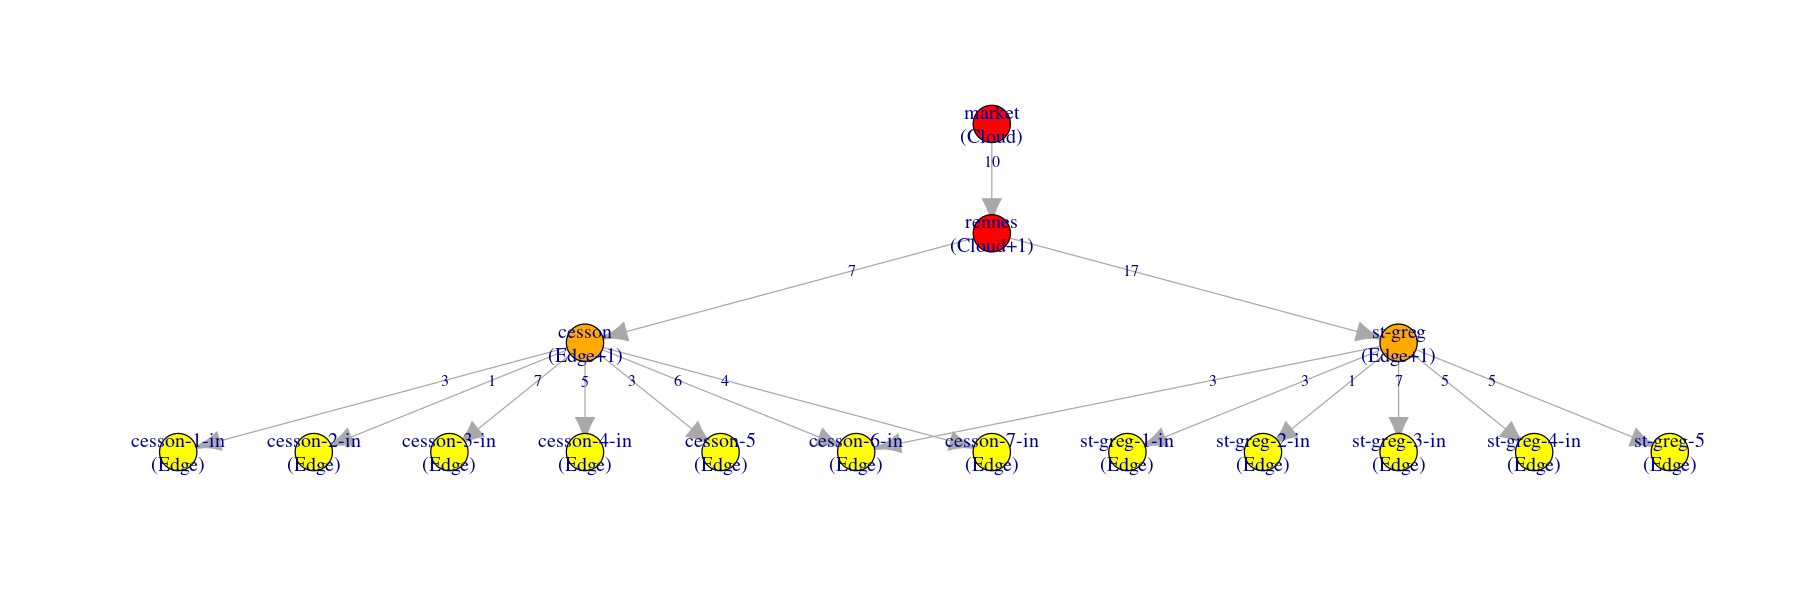

In [11]:
net_connected <- graph_from_adjacency_matrix(as.matrix(graph_matrix), weighted = TRUE)
colors <- heat.colors(length(unique(node_levels$level)))
colors <- c("#FF0000", "#FF0000", "#FFAA00", "#FFFF00", "#FFFF00")
node_level_map <- setNames(node_levels$level, node_levels$name)
color_map <- setNames(colors, unique(node_levels$level))
node_names <- merge(data.frame(name = V(net_connected)$name, stringsAsFactors = FALSE), node_levels, by.x = "name", by.y = "name")
node_names$name <- paste(node_names$name, paste("(", node_names$level, ")", sep = ""), sep = "\n")

V(net_connected)$color <- color_map[node_level_map[V(net_connected)$name]]
V(net_connected)$name <- node_names$name
# V(net_connected)$name <- ""
fig(15, 5)
coords <- layout_as_tree(net_connected)
# spacingfactor <- 40
# coords[, 1] <- coords[, 1] * spacingfactor
# coords[, 2] <- coords[, 2] * spacingfactor
node_graph <- plot(net_connected, layout = coords, asp = 0.22, margin = -0, vertex.label = E(net_connected)$name, edge.label = E(net_connected)$weight, edge.width = 1, vertex.size = 5, vertex.size2 = 3, vertex.label.cex = 1, vertex.dist = 20, edge.arrow.size = 0.5, edge.label.cex = 0.8, edge.label.dist = 1.5)
node_graph
fig(10, 10)


## Distribution of the functions in the network

Latency of the nodes from their rolling average

> It is actually the double of the set latency because first the TCP connection is established and then the data flows. So those are actually: src -> dest and then src -> dest, so counting twice as long as the actual network latency.

In [12]:
latency <- load_csv("fog_node_neighbors_latency_rolling_avg.csv") %>%
  prepare() %>%
  inner_join(names_raw %>% mutate(instance_to = instance) %>% mutate(destination_name = name) %>% select(-c(instance, name)), c("instance_to", "folder", "metric_group"))
latency_instants <- load_csv("fog_node_neighbors_latency.csv") %>%
  prepare() %>%
  inner_join(names_raw %>% mutate(instance_to = instance) %>% mutate(destination_name = name) %>% select(-c(instance, name)), c("instance_to", "folder", "metric_group"))
latency_median <- load_csv("fog_node_neighbors_latency_rolling_median.csv") %>%
  prepare() %>%
  inner_join(names_raw %>% mutate(instance_to = instance) %>% mutate(destination_name = name) %>% select(-c(instance, name)), c("instance_to", "folder", "metric_group"))
latency_median_interquantile_range <- load_csv("fog_node_neighbors_latency_rolling_interquartile_range.csv") %>%
  prepare() %>%
  inner_join(names_raw %>% mutate(instance_to = instance) %>% mutate(destination_name = name) %>% select(-c(instance, name)), c("instance_to", "folder", "metric_group"))

latency_goals <- latency %>%
  ungroup() %>%
  select(destination_name, instance) %>%
  distinct() %>%
  rowwise() %>%
  mutate(goal = max(graph_matrix[instance, destination_name], graph_matrix[destination_name, instance]))
# mutate(goal = graph_matrix[destination_name, instance])

latency <- latency %>%
  select(destination_name, value, instance, timestamp, folder, metric_group) %>%
  inner_join(latency_goals, by = c("instance", "destination_name")) %>%
  mutate(value = value) %>%
  mutate(diff = value - goal)

latency_instants <- latency_instants %>%
  select(destination_name, value, instance, timestamp, folder, metric_group) %>%
  inner_join(latency_goals, by = c("instance", "destination_name")) %>%
  mutate(value = 1000 * value) %>%
  mutate(diff = value - goal)

latency_median <- latency_median %>%
  select(destination_name, value, instance, timestamp, folder, metric_group) %>%
  inner_join(latency_goals, by = c("instance", "destination_name")) %>%
  mutate(value = value) %>%
  mutate(diff = value - goal)
# latency_goals
# head(latency_goals %>% filter(destination_name == "st-greg"))
# head(latency %>% filter(destination_name == "st-greg"))


Joining, by = c("destination_name", "value", "instance", "timestamp", "folder", "metric_group", "goal", "diff", "type")
Joining, by = c("destination_name", "value", "instance", "timestamp", "folder", "metric_group", "goal", "diff", "type")
Joining, by = c("destination_name", "value", "instance", "timestamp", "folder", "metric_group", "diff", "type")
`summarise()` has grouped output by 'instance', 'destination_name', 'folder', 'metric_group', 'type'. You can override using the `.groups` argument.
Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.



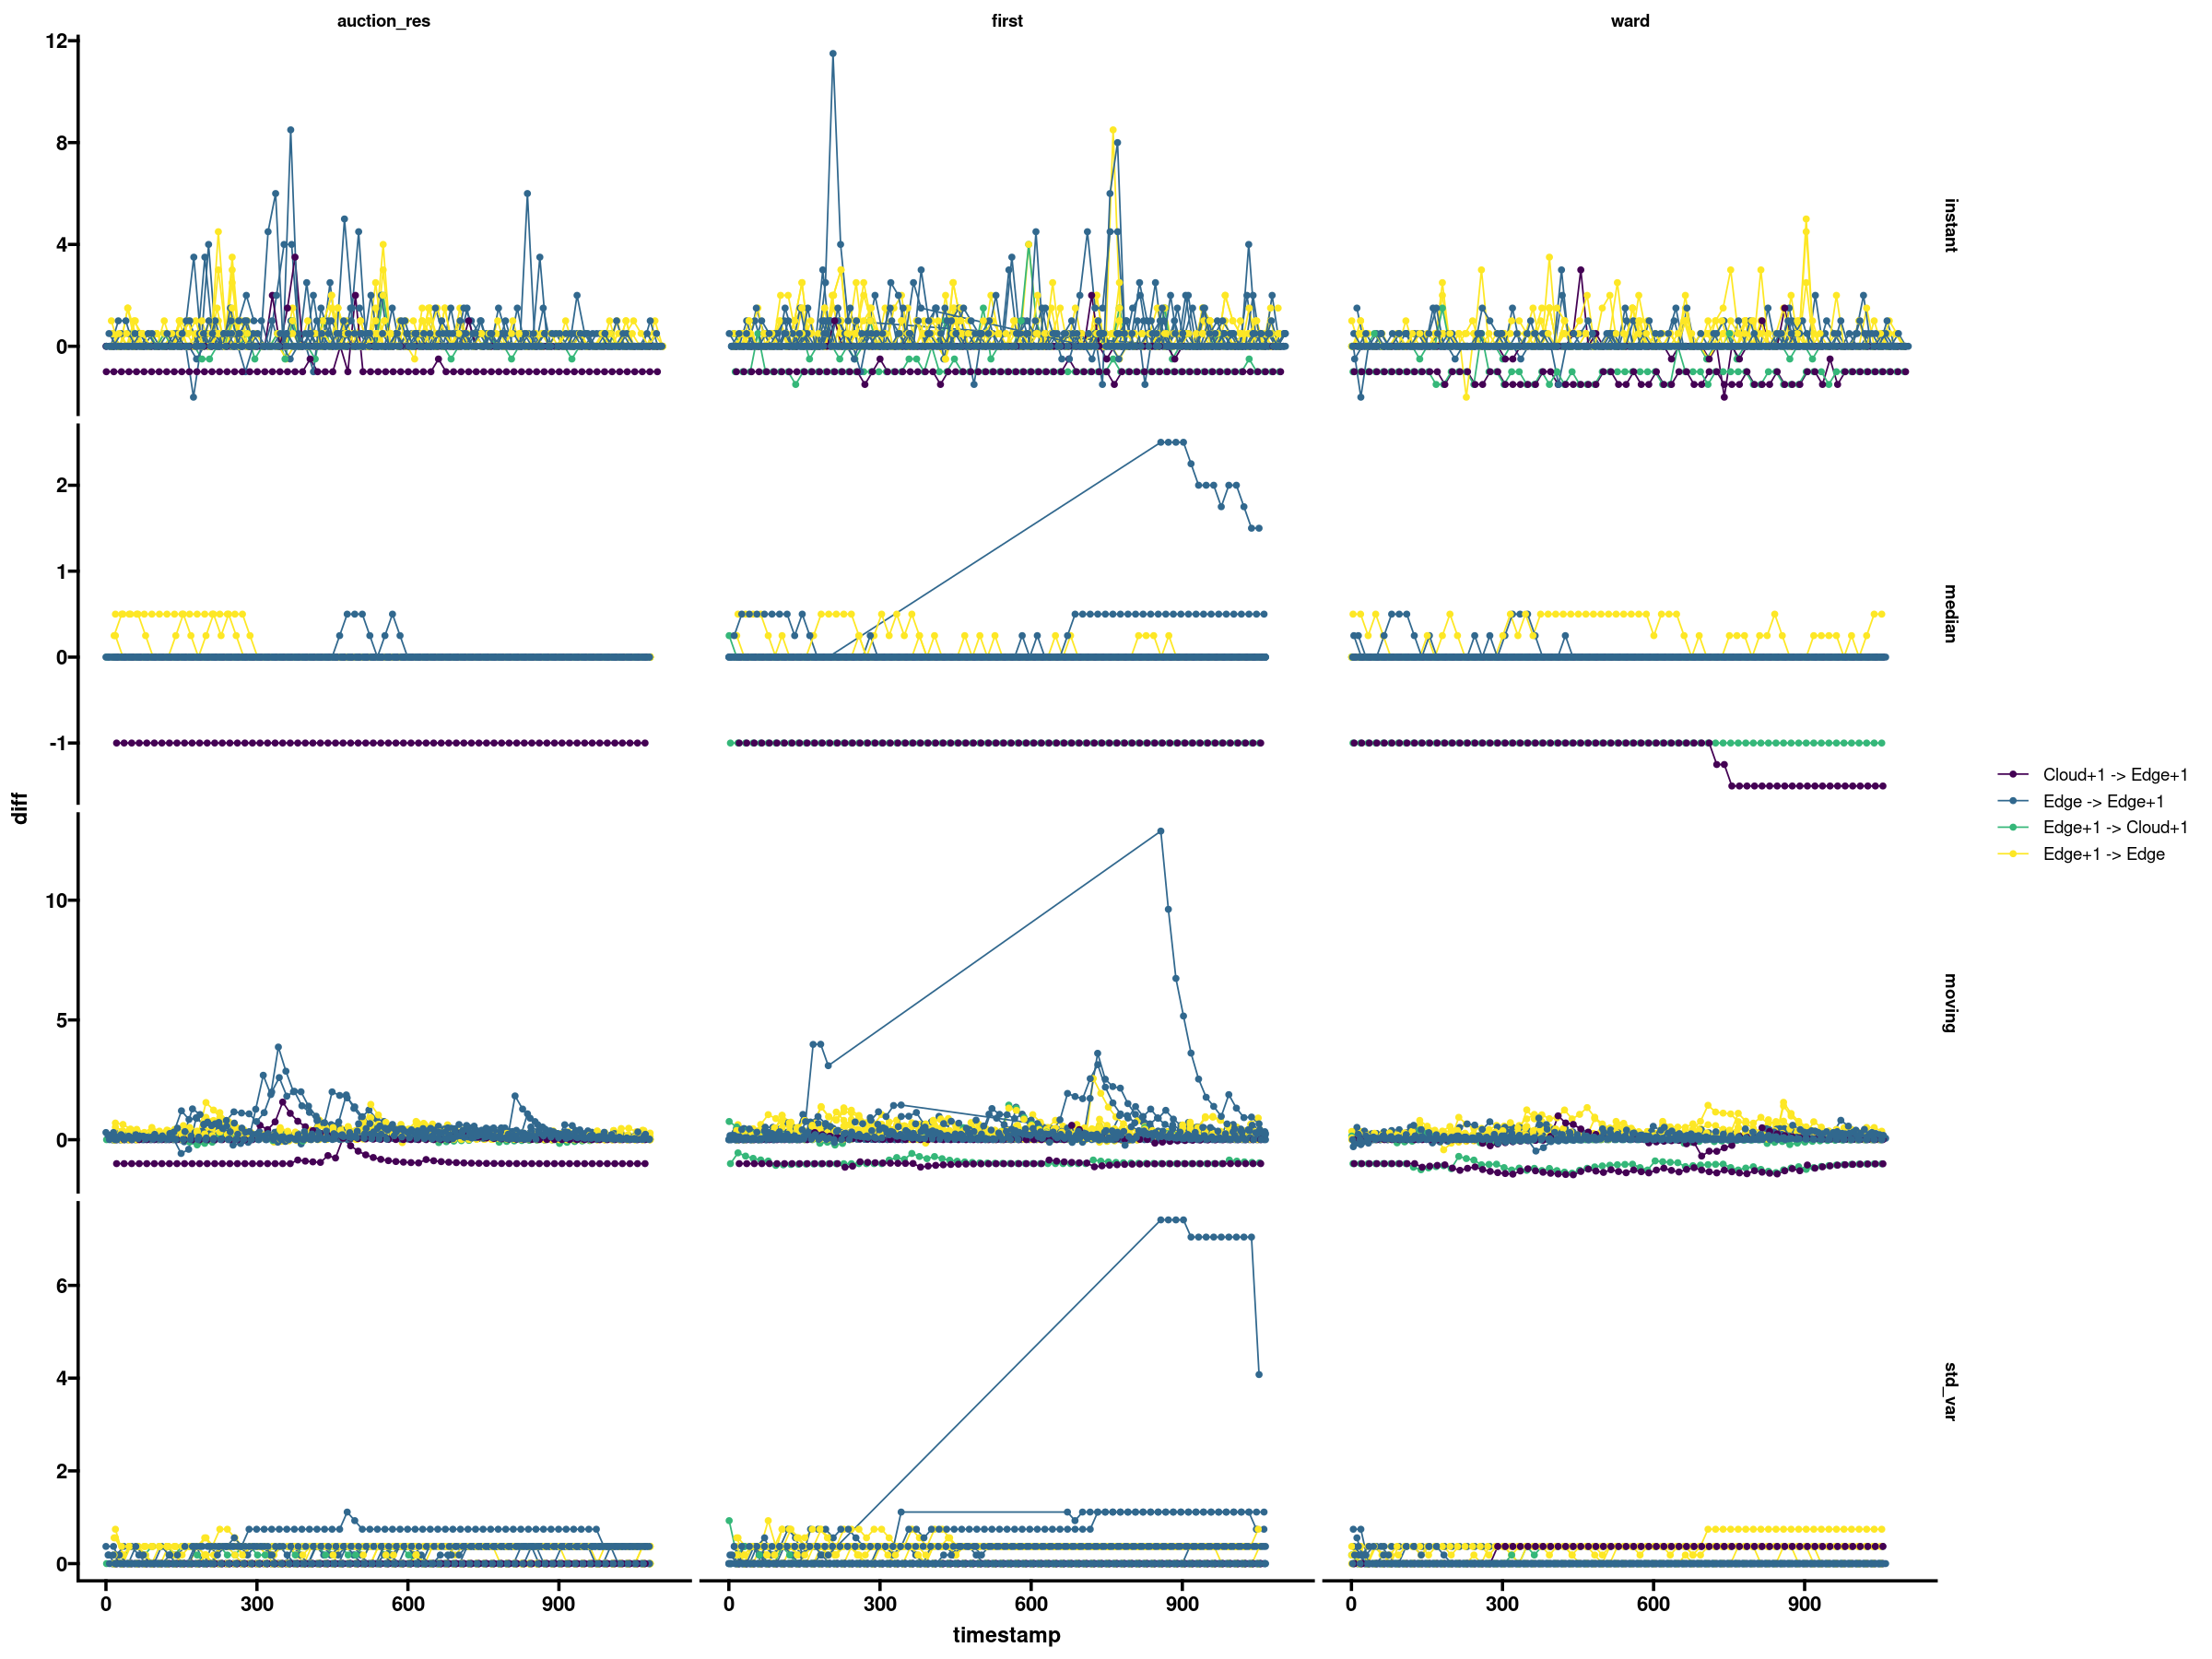

In [13]:
latency_data_raw <- latency %>%
  mutate(type = "moving") %>%
  full_join(latency_instants %>% mutate(type = "instant")) %>%
  full_join(latency_median %>% mutate(type = "median")) %>%
  # full_join(latency_median_interquantile_range %>% mutate(type = "interquantile", diff = value)) %>%
  full_join(latency_median_interquantile_range %>% mutate(type = "std_var", diff = value / 1.349)) %>%
  inner_join(node_levels %>% mutate(destination_name = name, destination_level = level) %>% select(-c("level", "name")), by = c("destination_name")) %>%
  inner_join(node_levels %>% mutate(instance = name, instance_level = level) %>% select(-c("level", "name")), by = c("instance"))



latency_data <- latency_data_raw %>%
  # group_by(instance, folder, metric_group) %>%
  # arrange(timestamp, .by_group = TRUE) %>%
  # summarise(auc = sum(diff(timestamp) * rollmean(value, 2))) %>%
  group_by(instance, destination_name, folder, metric_group, type) %>%
  summarise(
    quantile = scales::percent(c(0.01, 0.25, 0.5, 0.75, 0.95, 0.99)),
    diff = quantile(diff, c(0.01, 0.25, 0.5, 0.75, 0.95, 0.99))
  ) %>%
  # pivot_longer(cols = -c("instance", "instance_to", "folder"), names_to = c("quantile")) %>%
  {
    .
  }

# head(latency)
fig(20, 15)

latency_data_raw %>%
  group_by(folder, instance, destination_name) %>%
  filter(any(abs(diff) > 1)) %>%
  ggplot(
    aes(
      x = timestamp,
      group = factor(str_replace(interaction(instance, destination_name), "\\.", " -> "), ordered = TRUE),
      color = factor(str_replace(interaction(instance_level, destination_level), "\\.", " -> "), ordered = TRUE),
      y = diff,
    )
  ) +
  geom_line() +
  geom_point() +
  facet_grid(cols = vars(metric_group), rows = vars(type), scale = "free") +
  # facet_grid(cols = vars(folder), rows = vars(type), scale = "free") +
  theme(
    # legend.position = "none"
  )


In [14]:
# # Load necessary libraries
# library(plotly)

# # Prepare the data
# pdf <- NULL
# for (p in 1:10){
#    x <- pi*(-100:100)/100
#    y <- sin(x*p)
#    df <- data.frame(x, y, p)
#    pdf <- rbind(pdf, df)
# }

# # Create the plot with animation controls
# plt <- plot_ly(pdf, x = ~x, y = ~y, frame = ~p, type = 'scatter', mode = 'lines') %>%
#   animation_opts(frame = 100, transition = 0, redraw = TRUE) %>%
#   animation_button(x = 1, xanchor = "right", y = 0, yanchor = "bottom")

# # Display the plot
# plt


In [15]:
# # net <- graph_from_adjacency_matrix(as.matrix(graph_matrix), weighted = TRUE)
# data <- latency %>%
#   rename(source = instance, destination = destination_name) %>%
#   select(timestamp, source, destination, folder, value, diff) %>%
#   ungroup()

# nodes <- load_csv("fog_node_provisioned_functions.csv") %>%
#   prepare() %>%
#   group_by(folder, timestamp, instance) %>%
#   summarise(provisioned = sum(value)) %>%
#   rename(source = instance) %>%
#   select(source, everything()) %>%
#   ungroup()

# data$timestamp <- round(data$timestamp)
# nodes$timestamp <- round(nodes$timestamp)
# timestamps <- as.difftime(unique(data$timestamp), unit = "secs")
# all_combinations <- data %>%
#   select(folder, source, destination) %>%
#   distinct() %>%
#   full_join(data %>% select(timestamp) %>% distinct() %>% full_join(nodes %>% select(timestamp) %>% distinct(), by ="timestamp"), by = character())

# data <- all_combinations %>%
#   left_join(data, by = c("timestamp", "folder", "source", "destination")) %>%
#   left_join(nodes, by = c("source", "timestamp", "folder")) %>%
#   group_by(folder, source, destination) %>%
#   arrange(timestamp, .by_group = TRUE) %>%
#   fill(value, diff, provisioned) %>%
#   mutate(provisioned = ifelse(is.na(provisioned), 0, provisioned)) %>%
#   mutate(diff = ifelse(is.na(diff), 0, diff)) %>%
#   ungroup() %>%
#   {
#     .
#   }

# data <- data %>%
#   filter(source != destination) %>%
#   # drop_na() %>%
#   select(source, destination, everything()) %>%
#   rename(from = source, to = destination)
# net <- network(data, directed = TRUE, multiple=TRUE)

# fig(10, 10)
# pggnetwork <-
#   ggplot(
#      ggnetwork(net, layout=coords, by = "folder"),
#     aes(x = x, y = y, xend = xend, yend = yend)
#   ) + # mapping for edges
#   geom_edges(
#     arrow = arrow(length = unit(3, "pt"), type = "open"), # if directed
#     # color = "grey50",
#     curvature = 0.1,
#     alpha = 0.2,
#     aes(size = diff, colour = diff)
#   ) +
#   geom_nodes(aes(size = provisioned),
#     alpha = 0.5,
#   ) +
#   # geom_edgelabel(aes(label = round(value)), color = "grey50", fill = "white") +
#   scale_colour_gradient(low = "green", high = "red", na.value = "grey50") +
#   # facet_wrap(~folder) +
#   # transition_time(timestamp) +
#   labs(title = "Time: {frame_time}") +
#   transition_time(timestamp) +
#   ease_aes("linear") +
#   enter_fade() +
#   exit_fade() +
#   theme_blank() +
#   facet_wrap(~folder)

# out <- ggplot_build(pggnetwork)

# rows = max(out$layout$layout$ROW)
# cols = max(out$layout$layout$COL)

# anim_save("animation.gif", pggnetwork, height = 500 * rows, width = 500 * cols)


## Bids

In [16]:
functions <- tryCatch(
    {
        load_csv("market_refused_functions.csv") %>%
            prepare() %>%
            extract_function_name_info() %>%
            select(instance, sla_id, folder, metric_group, metric_group_group, load_type, latency_type) %>%
            distinct() %>%
            mutate(status = "refused") %>%
            group_by(instance, folder, metric_group, metric_group_group, load_type, latency_type, status) %>%
            summarise(n = n())
    },
    error = function(cond) {
        # columns <- c("instance", "sla_id", "folder", "metric_group", "metric_group_group", "load_type", "latency_type", "n")
        df <- data.frame(instance = character(0), sla_id = character(0), folder = character(0), metric_group = character(0), metric_group_group = character(0), load_type = character(0), latency_type = character(0), status = character(0), n = numeric(0))
        return(df)
    }
)

functions <- load_csv("market_provisioned_functions.csv") %>%
    prepare() %>%
    extract_function_name_info() %>%
    select(instance, sla_id, folder, metric_group, metric_group_group, load_type, latency_type) %>%
    distinct() %>%
    mutate(status = "provisioned") %>%
    group_by(instance, folder, metric_group, metric_group_group, load_type, latency_type, status) %>%
    summarise(n = n()) %>%
    full_join(functions, by = c("instance", "folder", "metric_group", "metric_group_group", "load_type", "latency_type", "status", "n")) %>%
    {
        .
    }

# functions


`summarise()` has grouped output by 'instance', 'folder', 'metric_group', 'metric_group_group', 'load_type', 'latency_type'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'instance', 'folder', 'metric_group', 'metric_group_group', 'load_type', 'latency_type'. You can override using the `.groups`
argument.


`summarise()` has grouped output by 'folder', 'instance', 'metric_group', 'metric_group_group', 'load_type'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'folder', 'status', 'metric_group', 'metric_group_group', 'load_type'. You can override using the `.groups` argument.


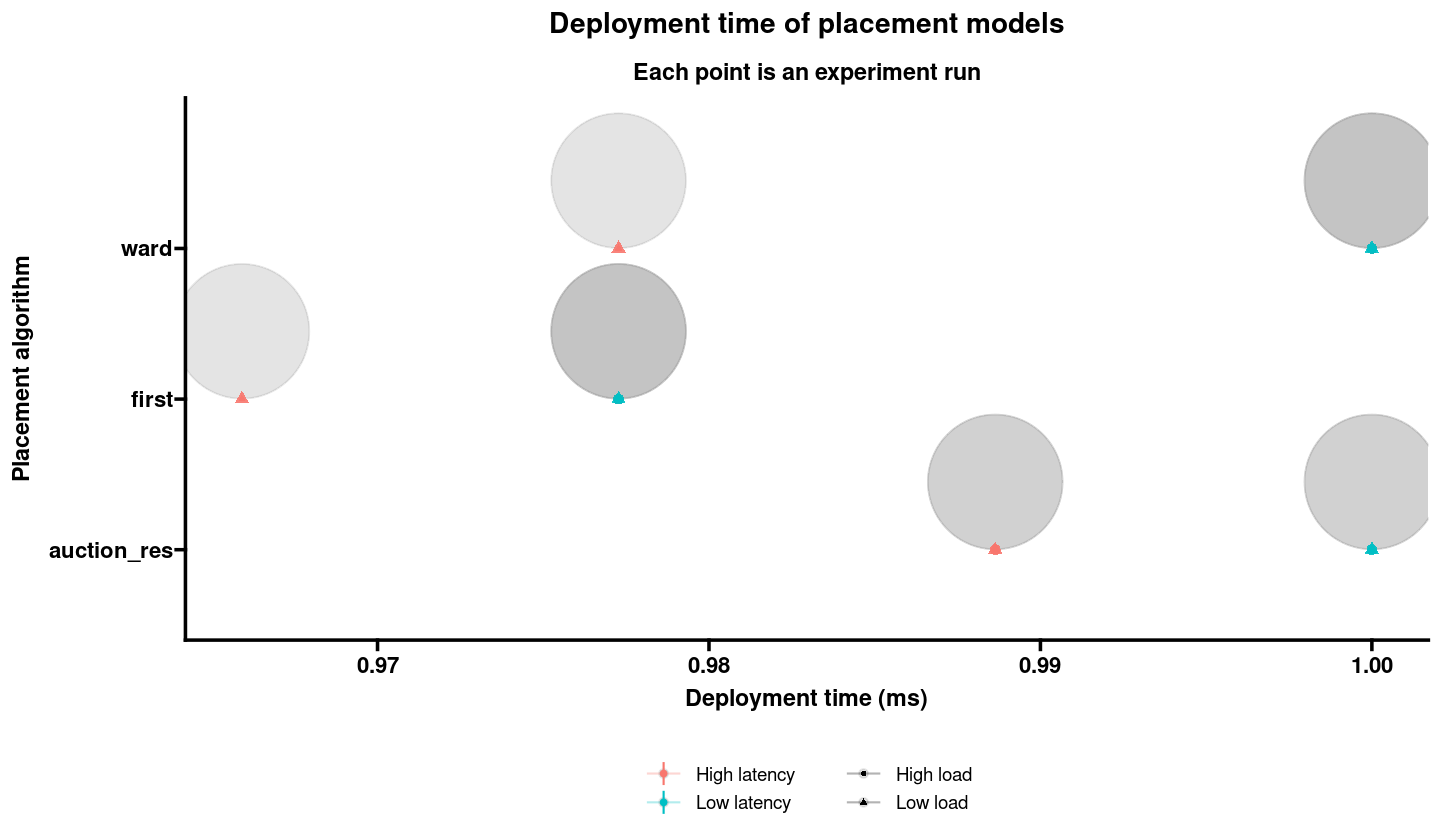

In [17]:
total <- functions %>%
    group_by(folder, instance, metric_group, metric_group_group, load_type, latency_type) %>%
    summarise(total = sum(n))
functions_total <- functions %>%
    inner_join(total, by = c("instance", "folder", "metric_group", "metric_group_group", "load_type", "latency_type")) %>%
    # inner_join(node_levels %>% mutate(instance = name) %>% select(-name), by = c("instance")) %>%
    group_by(folder, status, metric_group, metric_group_group, load_type, latency_type) %>%
    summarise(total = sum(total), n = sum(n)) %>%
    mutate(ratio = n / total) %>%
    {
        .
    }

fig(12, 7)

# functions_total %>% select(metric_group) %>%
functions_total %>%
    # ungroup() %>%
    filter(status == "provisioned") %>%
    correct_names() %>%
    ggplot(
        aes(
            y = `Placement method`,
            x = ratio,
            # color = factor(str_replace(interaction(load_type, latency_type), "\\.", ", ")),
            # shape = factor(str_replace(interaction(load_type, latency_type), "\\.", ", "))
            color = latency_type,
            shape = load_type,
        )
    ) +
    # geom_point()  +
    stat_dotsinterval() +
    # stat_dotsinterval(position = "dodge", point_interval = mode_hdci, point_alpha = 1) +
    gghighlight(metric_group == "auction", unhighlighted_params = list(point_alpha = 0.9, colour = NULL, fill = NULL, alpha = 0.3), label_params = list(linewidth = 10), calculate_per_facet = TRUE) +
    # facet_grid(cols = vars(average_type), scales = "free") +
    labs(
        x = "Deployment time (ms)",
        y = "Placement algorithm",
        title = "Deployment time of placement models",
        subtitle = "Each point is an experiment run",
        color = "Function type",
        shape = "Function type",
    ) +
    theme(
        legend.position = "bottom",
        legend.direction = "vertical",
    )


In [18]:
bids_raw <- load_csv("fog_node_bids.csv") %>% prepare()


`summarise()` has grouped output by 'sla_id', 'folder', 'metric_group', 'metric_group_group', 'latency_type'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'folder', 'metric_group', 'metric_group_group'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'folder', 'metric_group', 'metric_group_group'. You can override using the `.groups` argument.
Warning message:
“Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation...”


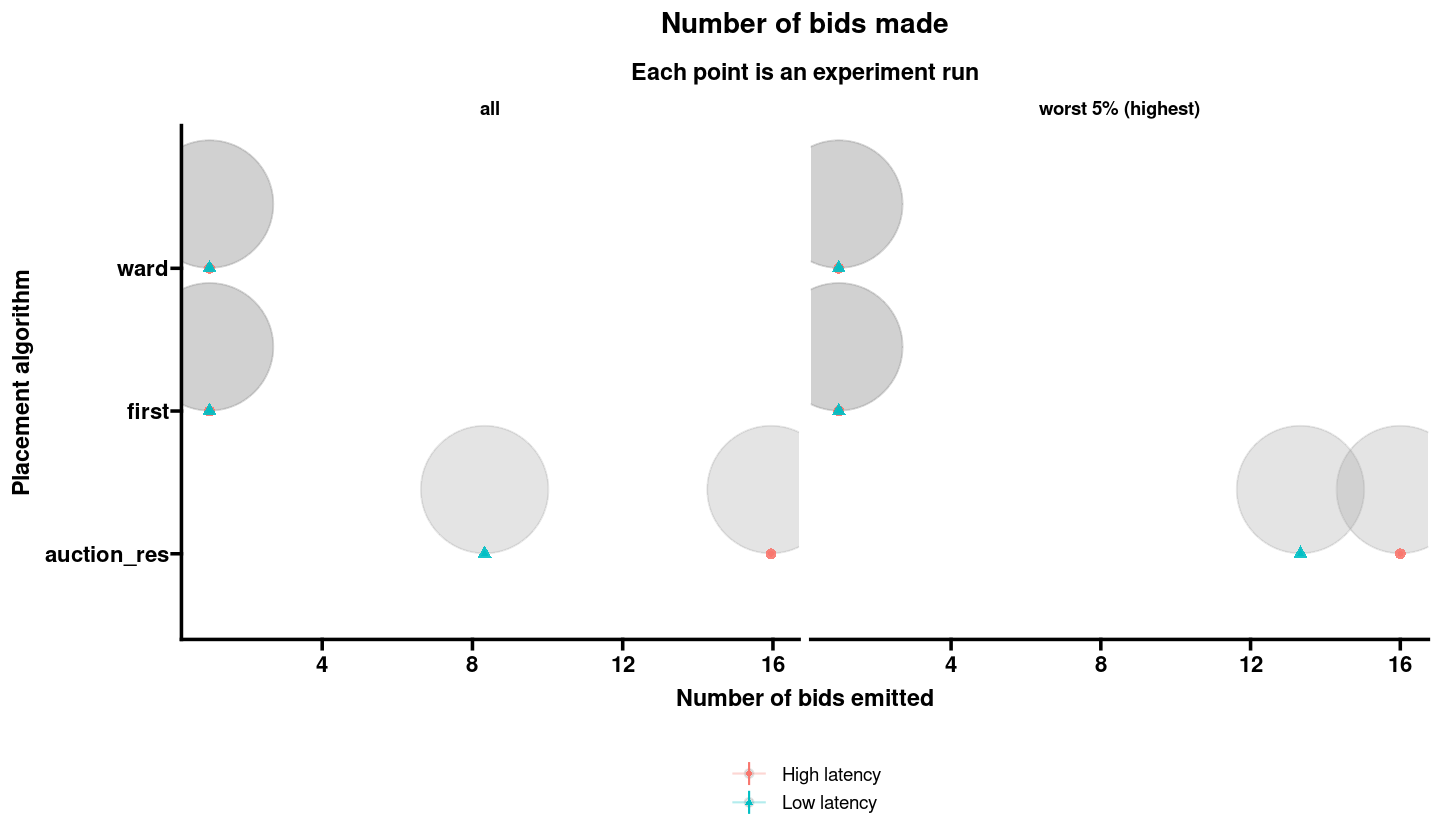

In [19]:
bids_function <- bids_raw %>%
  # inner_join(node_levels %>% mutate(instance = name) %>% select(-name), by = c("instance")) %>%
  select(instance, folder, metric_group, metric_group_group, function_name, sla_id, bid_id) %>%
  ungroup() %>%
  distinct() %>%
  extract_function_name_info() %>%
  group_by(sla_id, folder, metric_group, metric_group_group, latency_type, load_type) %>%
  summarise(n = n()) %>%
  {
    .
  }


top_1_percent <- bids_function %>%
  group_by(folder, metric_group, metric_group_group, latency_type) %>%
  arrange(desc(n), .by_group = T) %>%
  mutate(rank = row_number()) %>%
  filter(rank <= ceiling(n() * 0.05)) %>%
  group_by(folder, metric_group, metric_group_group, latency_type) %>%
  summarize(n_1_percent = mean(n))

bids_function <- bids_function %>%
  group_by(folder, metric_group, metric_group_group, latency_type) %>%
  summarize(n = mean(n)) %>%
  inner_join(top_1_percent, by = c("folder", "metric_group", "latency_type")) %>%
  gather(key = "n_type", value = "n", n, n_1_percent) %>%
  mutate(n_type = case_when(
    n_type == "n" ~ "all",
    n_type == "n_1_percent" ~ "worst 5% (highest)",
  )) %>%
  {
    .
  }


# bids_function
# fig(12, 5)
# bids_function_graph <- bids_function %>%
#   mutate(latency_load = factor(str_replace(interaction(load_type, latency_type), "\\.", ", "))) %>%
#   ggplot(
#     aes(
#       x = metric_group,
#       y = n,
#       fill = latency_load,
#       group = interaction(latency_load, metric_group),
#     )
#   ) +
#   labs(
#     title = "Number of bids (total) made by each placement models",
#     x = "placement models",
#     y = "Number of bids"
#   ) +
#   geom_boxplot(alpha = 0.3, position = position_dodge2()) +
#   # geom_violin(width = 0.85) +
#   # geom_boxplot(
#   #   position = position_dodge(width = 0.85),
#   #   width = 0.1,
#   #   color = "white"
#   #   # fill=transp,
#   #   # alpha = 0.2
#   # ) +
#   scale_color_viridis(discrete = TRUE, option = "E") +
#   scale_fill_viridis(discrete = TRUE) +
#   theme(
#     # legend.position = "top",
#     # axis.title.x = element_blank(),
#     axis.text.x = element_text(angle = 45)
#   )
# bids_function_graph

bids_function_plot <- bids_function %>%
  correct_names() %>%
  ggplot(
    aes(
      y = `Placement method`,
      x = n,
      color = latency_type,
      shape = latency_type
      # dotsize = 0.6,
      # bindwidth=0.5,
      # # group = average_type,
      # linewidth=0,
    )
  ) +
  stat_dotsinterval() +
  # stat_dotsinterval(position = "dodge", point_interval = mode_hdci, point_alpha = 0.1) +
  # gghighlight(metric_group == "auction", unhighlighted_params = list(point_alpha = 0.9, scale = 0.8, bindwidth = 0.6, dotsize = 0.6, colour = NULL, fill = NULL, alpha = 0.3), label_params = list(linewidth = 10), calculate_per_facet = TRUE) +
  gghighlight(metric_group == "auction", unhighlighted_params = list(point_alpha = 0.9, colour = NULL, fill = NULL, alpha = 0.3), label_params = list(linewidth = 10), calculate_per_facet = TRUE) +
  facet_grid(cols = vars(n_type), scales = "free") +
  labs(
    x = "Number of bids emitted",
    y = "Placement algorithm",
    title = "Number of bids made",
    subtitle = "Each point is an experiment run",
    color = "Function type",
    shape = "Function type",
  ) +
  theme(
    legend.position = "bottom",
    legend.direction = "vertical",
  )
bids_function_plot


In [20]:
provisioned_sla <- load_csv("market_function_deployment_time.csv") %>%
  prepare() %>%
  select(bid_id, sla_id, folder, metric_group, metric_group_group) %>%
  distinct() %>%
  {
    .
  }
# provisioned_sla


In [21]:
# provisioned_sla

bids_won_function <- bids_raw %>%
  select(sla_id, bid_id, instance, function_name, folder, metric_group, metric_group_group, value) %>%
  distinct() %>%
  inner_join(provisioned_sla, by = c("bid_id", "sla_id", "folder", "metric_group", "metric_group_group")) %>%
  # group_by(sla_id, instance, function_name, folder, metric_group, metric_group_group) %>%
  # arrange(desc(value), .by_group = TRUE) %>%
  # mutate(second_price = lag(value)) %>%
  # mutate(second_price = ifelse(is.na(second_price), value, second_price)) %>%
  # slice(which.min(value)) %>%
  mutate(winner = instance) %>%
  mutate(cost = value) %>%
  select(sla_id, function_name, folder, metric_group, metric_group_group, winner, cost) %>%
  {
    .
  }
# bids_won_function
# bids_won_function %>% group_by(sla_id, function_name, folder, metric_group, metric_group_group) %>% filter(n() > 1)
# head(bids_won_function %>% filter(sla_id=="466f56bb-9fa5-443d-9862-86d8c13a01bf"))


In [22]:
cpu_used <- load_csv("fog_node_cpu_used.csv") %>% prepare()
cpu_avail <- load_csv("fog_node_cpu_available.csv") %>% prepare()


New names:
• `name` -> `name...1`
• `name` -> `name...4`
New names:
• `name` -> `name...1`
• `name` -> `name...4`
New names:
• `name` -> `name...1`
• `name` -> `name...4`
New names:
• `name` -> `name...1`
• `name` -> `name...4`
New names:
• `name` -> `name...1`
• `name` -> `name...4`
New names:
• `name` -> `name...1`
• `name` -> `name...4`


In [23]:
max_timestamp_cpu <- cpu_used %>%
    select(timestamp, instance, folder) %>%
    group_by(instance, folder) %>%
    summarise(max = max(timestamp))


`summarise()` has grouped output by 'instance'. You can override using the `.groups` argument.


In [24]:
auc_usage <- cpu_used %>%
    inner_join(cpu_avail, by = c("instance", "timestamp", "folder", "metric_group", "metric_group_group")) %>%
    mutate(usage = value.x / value.y) %>%
    # mutate(usage = value.y) %>%
    select(instance, timestamp, usage, folder, metric_group, metric_group_group)

auc_usage <- auc_usage %>%
    drop_na() %>%
    distinct() %>%
    group_by(instance, folder, metric_group, metric_group_group) %>%
    arrange(timestamp, .by_group = TRUE) %>%
    summarise(usage = sum(diff(timestamp) * rollmean(usage, 2))) %>%
    inner_join(max_timestamp_cpu, by = c("instance", "folder")) %>%
    mutate(usage_ratio = usage / as.numeric(max)) %>% # * 100%
    {
        .
    }

folders <- auc_usage %>%
    ungroup() %>%
    select(folder, metric_group, metric_group_group) %>%
    distinct()

missing_data <- expand.grid(
    instance = node_levels$name,
    folder = folders$folder
) %>%
    # inner_join(node_levels %>% mutate(winner = name) %>% select(-name), by = c("winner")) %>%
    inner_join(folders, by = c("folder"))

auc_usage <- auc_usage %>%
    ungroup() %>%
    full_join(missing_data, by = c("instance", "folder", "metric_group", "metric_group_group")) %>%
    ungroup() %>%
    {
        .
    }

auc_usage$usage_ratio[is.na(auc_usage$usage_ratio)] <- 0


`summarise()` has grouped output by 'instance', 'folder', 'metric_group'. You can override using the `.groups` argument.


In [25]:
total_gains <- bids_won_function %>%
    group_by(folder, metric_group, metric_group_group, winner) %>%
    summarise(earnings = sum(cost)) %>%
    {
        .
    }


`summarise()` has grouped output by 'folder', 'metric_group', 'metric_group_group'. You can override using the `.groups` argument.


`summarise()` has grouped output by 'folder', 'metric_group', 'metric_group_group', 'winner', 'latency_type'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'folder', 'metric_group', 'metric_group_group', 'latency_type', 'load_type'. You can override using the `.groups` argument.


folder,metric_group,metric_group_group,latency_type,load_type,level,function_cost,nb_functions
<chr>,<chr>,<chr>,<chr>,<chr>,<ord>,<dbl>,<int>


Warning message:
“Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation...”
Warning message:
“Using shapes for an ordinal variable is not advised”


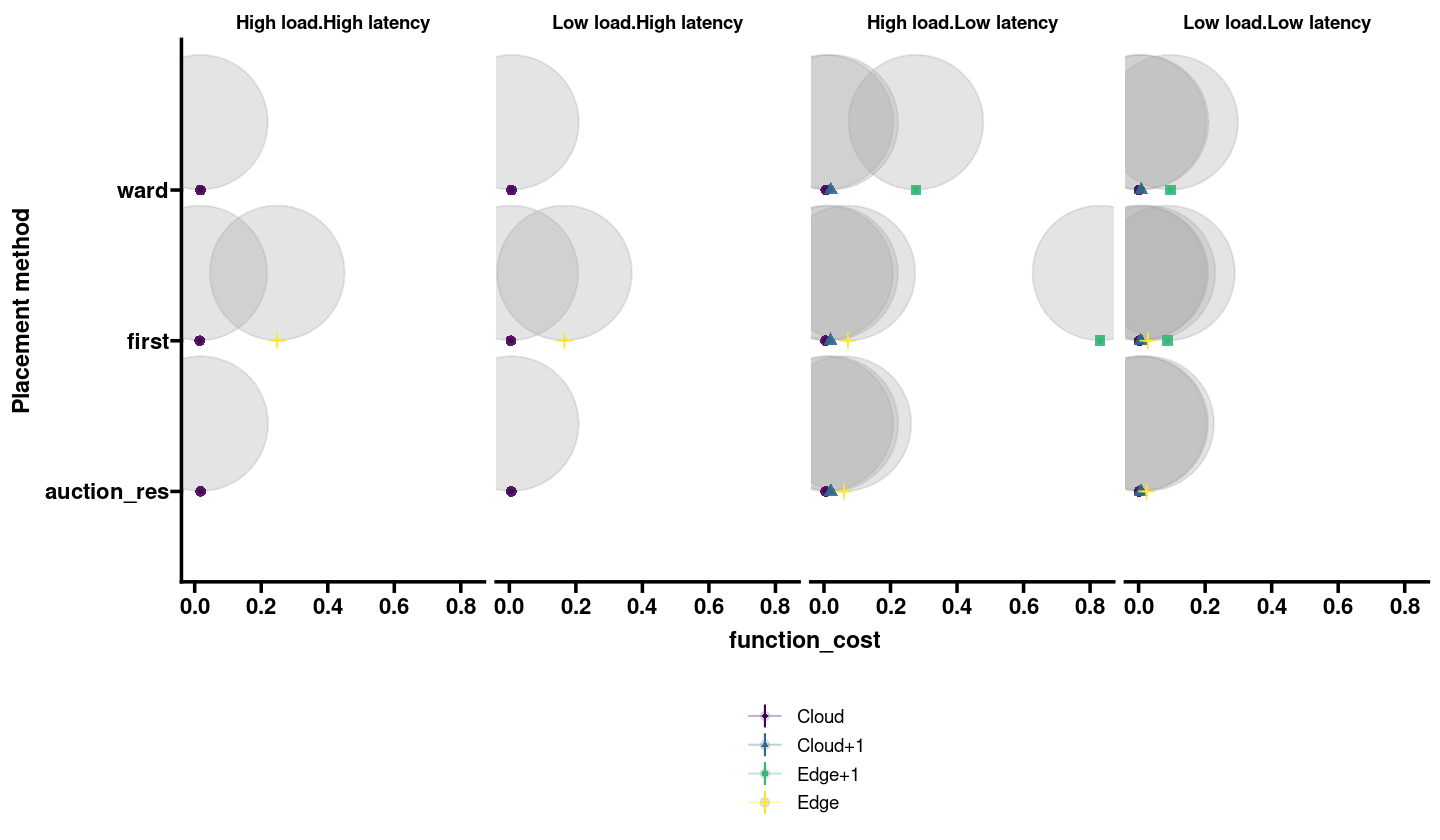

In [26]:
fig(12, 7)
value_of_bids <- bids_won_function %>%
    extract_function_name_info() %>%
    group_by(folder, metric_group, metric_group_group, winner, latency_type, load_type) %>%
    summarise(function_cost = mean(cost), nb_functions = n()) %>%
    inner_join(node_levels %>% mutate(winner = name) %>% select(-name), by = c("winner")) %>%
    group_by(folder, metric_group, metric_group_group, latency_type, load_type, level) %>%
    summarise(function_cost = mean(function_cost), nb_functions = sum(nb_functions)) %>%
    {
        .
    }

value_of_bids %>% filter(metric_group == "auction" & latency_type == "High latency" & load_type == "High load" & level == "Edge")

value_of_bids %>%
    correct_names() %>%
    ggplot(aes(
        x = function_cost,
        y = `Placement method`,
        color = level,
        shape = level
    )) +
    stat_dotsinterval() +
    # stat_dotsinterval(position = "dodge", point_interval = mode_hdci, point_alpha = 0.1) +
    gghighlight(metric_group == "auction", unhighlighted_params = list(point_alpha = 0.9, colour = NULL, fill = NULL, alpha = 0.3), label_params = list(linewidth = 10), calculate_per_facet = TRUE) +
    facet_grid(cols = vars(interaction(load_type, latency_type))) +
    #   labs(
    #     x = "Deployment time (ms)",
    #     y = "Placement algorithm",
    #     title = "Deployment time of placement models",
    #     subtitle = "Each point is an experiment run",
    #     color = "Function type",
    #     shape = "Function type",
    #   ) +
    theme(
        legend.position = "bottom",
        legend.direction = "vertical",
    )


In [27]:
grand_total_gains <- bids_won_function %>%
    group_by(folder, metric_group, metric_group_group) %>%
    summarise(grand_total = sum(cost))


`summarise()` has grouped output by 'folder', 'metric_group'. You can override using the `.groups` argument.


`summarise()` has grouped output by 'folder', 'metric_group', 'metric_group_group'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'metric_group', 'level'. You can override using the `.groups` argument.
Warning message:
“Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation...”
Warning message:
“Using shapes for an ordinal variable is not advised”
Warning message:
“Removed 6 rows containing missing values (geom_segment).”
Warning message:
“Removed 6 rows containing missing values (geom_segment).”
Warning message:
“Removed 6 rows containing missing values (geom_segment).”
Warning message:
“Removed 6 rows containing missing values (geom_segment).”


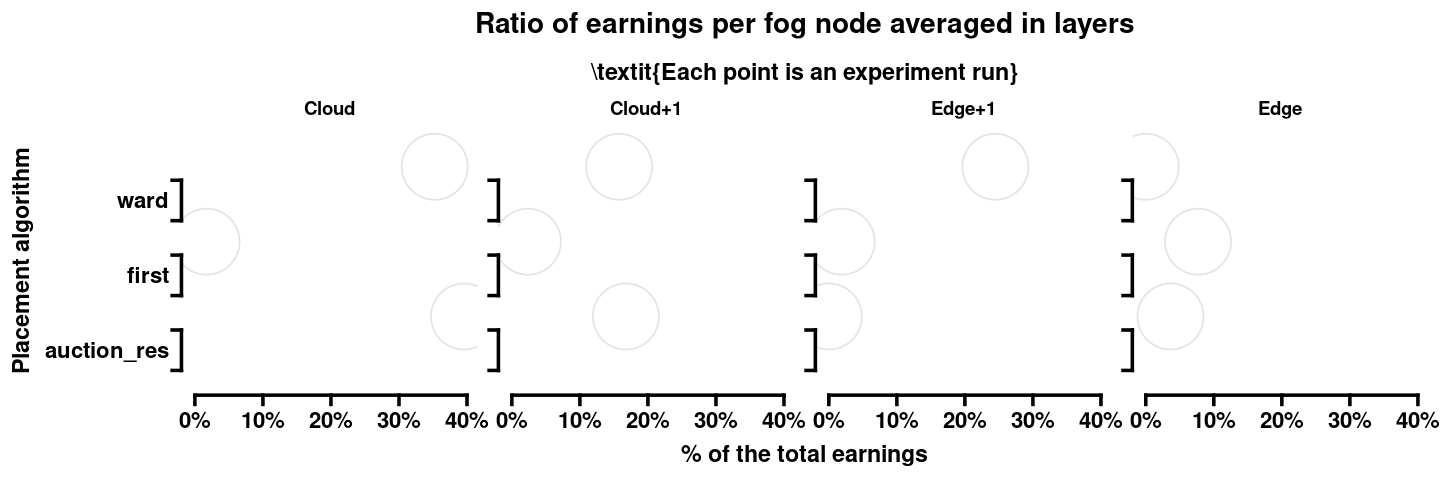

In [28]:
transform_ratio_graph <- auc_usage %>%
    mutate(winner = instance) %>%
    ungroup() %>%
    select(-instance) %>%
    inner_join(grand_total_gains, by = c("folder", "metric_group", "metric_group_group")) %>%
    inner_join(total_gains, by = c("folder", "metric_group", "metric_group_group", "winner")) %>%
    mutate(gains_ratio = earnings / grand_total) %>%
    inner_join(node_levels %>% mutate(winner = name) %>% select(-name), by = c("winner")) %>%
    {
        .
    }


folders <- transform_ratio_graph %>%
    select(folder, metric_group, metric_group_group) %>%
    distinct()
missing_data <- expand.grid(
    winner = node_levels$name,
    folder = folders$folder
) %>%
    inner_join(node_levels %>% mutate(winner = name) %>% select(-name), by = c("winner")) %>%
    inner_join(folders, by = c("folder"))

transform_ratio_graph <- transform_ratio_graph %>%
    full_join(missing_data, by = c("winner", "level", "folder", "metric_group", "metric_group_group")) %>%
    ungroup() %>%
    {
        .
    }
transform_ratio_graph$gains_ratio[is.na(transform_ratio_graph$gains_ratio)] <- 0

top_1_percent <- transform_ratio_graph %>%
    group_by(folder, metric_group, metric_group_group, level) %>%
    arrange(desc(gains_ratio), .by_group = TRUE) %>%
    mutate(rank = row_number()) %>%
    filter(rank <= ceiling(n() * 0.05)) %>%
    group_by(folder, metric_group, metric_group_group, level) %>%
    summarize(gains_ratio_1_percent = mean(gains_ratio))

transform_ratio_graph <- transform_ratio_graph %>%
    group_by(metric_group, level, folder) %>%
    summarise(gains_ratio = mean(gains_ratio)) %>%
    inner_join(top_1_percent, by = c("folder", "metric_group", "level")) %>%
    gather(key = "gains_ratio_type", value = "gains_ratio", gains_ratio, gains_ratio_1_percent) %>%
    mutate(gains_ratio_type = case_when(
        gains_ratio_type == "gains_ratio" ~ "all",
        gains_ratio_type == "gains_ratio_1_percent" ~ "5% highest",
    ))


transform_ratio_graph_plot_earnings <- transform_ratio_graph %>%
    filter(gains_ratio_type == "all") %>%
    correct_names() %>%
    ggplot(aes(
        x = gains_ratio,
        y = `Placement method`,
        color = metric_group,
        fill = metric_group,
        shape = metric_group
    )) +
    # stat_dotsinterval(binwidth = 0.0015, scale = 0.95, size = 7, slab_linewidth = 0) +
    stat_dotsinterval() +
    # stat_dotsinterval(position = "dodge", binwidth = 0.0015, scale = 0.95, size = 7, slab_linewidth = 0) +
    gghighlight(metric_group == "auction", unhighlighted_params = list(slab_alpha = 0.3, point_alpha = 0.3, colour = NULL, fill = NULL, alpha = 0.3), label_params = list(linewidth = 10), calculate_per_facet = TRUE) +
    scale_x_continuous(label = scales::percent) +
    facet_grid2(cols = vars(level), rows = vars(gains_ratio_type), axes = "all", remove_labels = "y") +
    labs(
        y = "Placement algorithm",
        x = "% of the total earnings",
        title = "Ratio of earnings per fog node averaged in layers",
        subtitle = "\\textit{Each point is an experiment run}",
        fill = "Function type",
        color = "Function type",
        shape = "Function type"
    ) +
    theme(
        legend.position = "none",
        strip.text.y = element_blank()
    ) +
    coord_capped_cart(bottom = "both") +
    scale_y_discrete(guide = guide_prism_bracket(width = 0.15))
fig(12, 4)
transform_ratio_graph_plot_earnings


`summarise()` has grouped output by 'folder'. You can override using the `.groups` argument.


x_category,min,max,med,size,max_size,scale
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<list>
b1,-13.74,27.14,6.7,30.74,40.88,<environment: 0xd73dad0>


folder,metric_group,earnings,x_category
<chr>,<chr>,<dbl>,<fct>
metrics_valuation_rates_streaming11_2-auction_valuation_resources_no-telemetry_2023-05-26-14-37,auction_res,5.676047,b1
metrics_valuation_rates_streaming11_2-edge_first_v2_valuation_resources_no-telemetry_2023-05-26-15-30,first,36.421648,b1
metrics_valuation_rates_streaming11_2-edge_ward_v3_valuation_resources_no-telemetry_2023-05-26-15-04,ward,6.698321,b1


Warning message:
“Ignoring unknown parameters: slab_linewidth”
Warning message:
“Using shapes for an ordinal variable is not advised”
Warning message:
“Removed 6 rows containing missing values (geom_segment).”


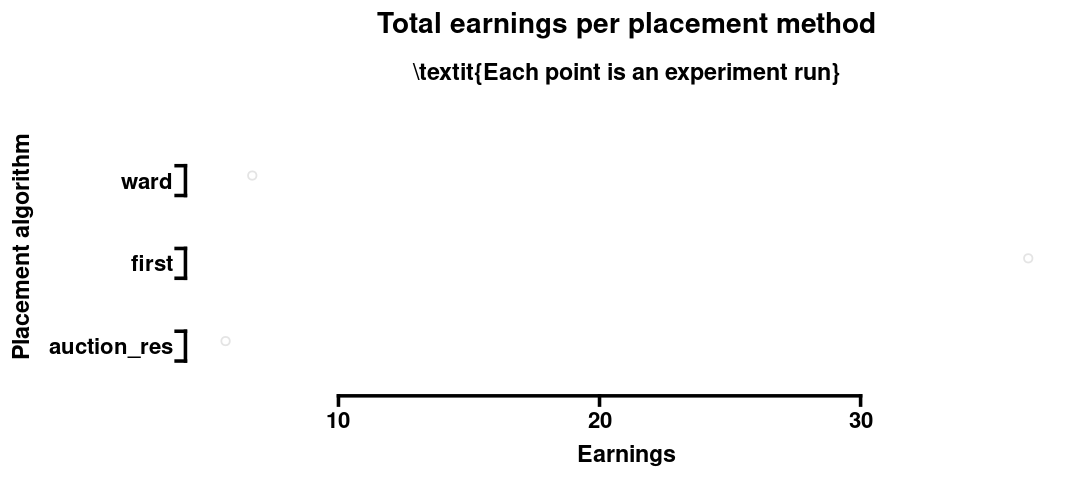

In [29]:
grand_total_gains_local <- grand_total_gains %>%
  group_by(folder, metric_group) %>%
  summarise(earnings = sum(grand_total))
categorize_x <- function(x) {
  if (x <= 130000) {
    return("b1")
  } else {
    return("b2")
  }
}

grand_total_gains_local$x_category <- as.factor(sapply(grand_total_gains_local$earnings, categorize_x))

maxmin <- grand_total_gains_local %>%
  group_by(x_category) %>%
  summarise(min = min(earnings), max = max(earnings), med = median(earnings)) %>%
  mutate(min = -1 * round(-1 * min, 2), max = round(max, 2)) %>%
  mutate(size = max - min)

maxmin <- maxmin %>%
  full_join(maxmin %>% ungroup() %>% summarise(max_size = max(size)), by = character()) %>% # cross join
  mutate(max_size = round(max_size * 1.33, 2), med = round(med, 2)) %>%
  mutate(min = -1 * round(-1 * (med - max_size / 2), 2), max = round(med + max_size / 2, 2)) %>%
  rowwise() %>%
  mutate(scale = c(scale_x_continuous(limits = c(min, max), breaks = seq(min, max, max_size / 2))))

maxmin
grand_total_gains_local
transform_ratio_graph_plot_sum_earnings <- grand_total_gains_local %>%
  correct_names() %>%
  ggplot(aes(
    x = earnings,
    y = `Placement method`,
    color = metric_group,
    fill = metric_group,
    shape = metric_group
  )) +
  stat_dotsinterval(position = "dodge", binwidth = unit(2, "mm"), scale = 0.95, size = 7, slab_linewidth = 0) +
  gghighlight(metric_group == "auction", unhighlighted_params = list(slab_alpha = 0.3, point_alpha = 0.3, colour = NULL, fill = NULL, alpha = 0.3), label_params = list(linewidth = 10), calculate_per_facet = TRUE) +
  # scale_x_continuous(label = scales::percent) +
  # facet_grid2(rows = vars(earnings_type), axes = "all", remove_labels = "y", scales="free_x") +
  labs(
    y = "Placement algorithm",
    x = "Earnings",
    title = "Total earnings per placement method",
    subtitle = "\\textit{Each point is an experiment run}",
    fill = "Function type",
    color = "Function type",
    shape = "Function type"
  ) +
  theme(
    legend.position = "none",
    strip.text.x = element_blank()
  ) +
  # facet_grid2(cols = vars(x_category), scales = "free_x") +
  # facetted_pos_scales(
  #   x = list(
  #     maxmin$scale[[1]],
  #     maxmin$scale[[2]]
  #   )
  # ) +
  # coord_cartesian(clip = "off") +
  # guides(x = guide_axis_truncated(trunc_lower = c(maxmin$min[[2]], maxmin$min[[1]]), trunc_upper = c(maxmin$max[[2]], maxmin$max[[1]]))) +
  # annotate("text", x = c(0, maxmin$max[[1]]), y = 0, label = "/ /", size = 10, vjust = 0.5) +
  scale_y_discrete(guide = guide_prism_bracket(width = 0.1)) +
  coord_capped_cart(bottom = "both")

# guides(x = guide_axis_truncated(trunc_lower = maxmin$min, trunc_upper = maxmin$max))



fig(9, 4)
transform_ratio_graph_plot_sum_earnings


`summarise()` has grouped output by 'metric_group'. You can override using the `.groups` argument.
Warning message:
“Ignoring unknown parameters: slab_linewidth”
Warning message:
“Using shapes for an ordinal variable is not advised”
Warning message:
“Removed 6 rows containing missing values (geom_segment).”


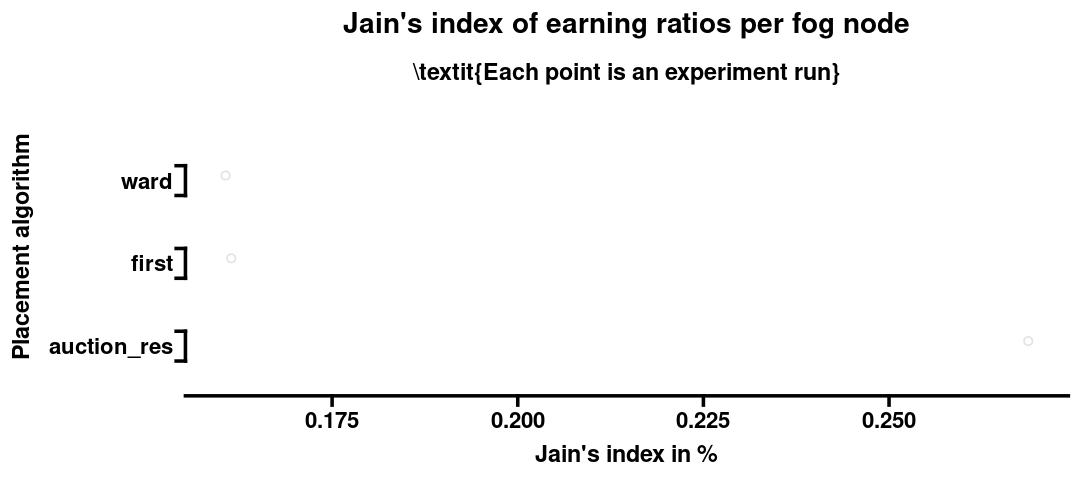

In [30]:
# Define a function to calculate Jain's Faisrness Index
jains_index <- function(allocations) {
  num_users <- length(allocations)
  sum_allocations <- sum(allocations)
  sum_square_allocations <- sum(allocations^2)

  index <- (sum_allocations^2) / (num_users * sum_square_allocations)
  return(index)
}

transform_ratio_graph <- auc_usage %>%
  mutate(winner = instance) %>%
  ungroup() %>%
  select(-instance) %>%
  inner_join(grand_total_gains, by = c("folder", "metric_group", "metric_group_group")) %>%
  inner_join(total_gains, by = c("folder", "metric_group", "metric_group_group", "winner")) %>%
  mutate(gains_ratio = earnings / grand_total) %>%
  {
    .
  }


folders <- transform_ratio_graph %>%
  select(folder, metric_group, metric_group_group) %>%
  distinct()
missing_data <- expand.grid(
  winner = node_levels$name,
  folder = folders$folder
) %>%
  inner_join(node_levels %>% mutate(winner = name) %>% select(-name), by = c("winner")) %>%
  inner_join(folders, by = c("folder"))

transform_ratio_graph <- transform_ratio_graph %>%
  full_join(missing_data, by = c("winner", "folder", "metric_group", "metric_group_group")) %>%
  ungroup() %>%
  {
    .
  }
transform_ratio_graph$gains_ratio[is.na(transform_ratio_graph$gains_ratio)] <- 0

# Calculate Jain's Fairness Index for each group using dplyr
transform_ratio_graph <- transform_ratio_graph %>%
  group_by(metric_group, folder) %>%
  summarise(jains_index = jains_index(gains_ratio), n = n())

# top_1_percent <- transform_ratio_graph %>%
#   group_by(folder, metric_group, metric_group_group, level) %>%
#   arrange(desc(gains_ratio), .by_group = TRUE) %>%
#   mutate(rank = row_number()) %>%
#   filter(rank <= ceiling(n() * 0.05)) %>%
#   group_by(folder, metric_group, metric_group_group, level) %>%
#   summarize(gains_ratio_1_percent = mean(gains_ratio))

# transform_ratio_graph <- transform_ratio_graph %>%
#   # group_by(metric_group, level, folder) %>%
#   # summarise(gains_ratio = mean(gains_ratio)) %>%
#   # inner_join(top_1_percent, by = c("folder", "metric_group", "level")) %>%
#   gather(key = "gains_ratio_type", value = "gains_ratio", gains_ratio, gains_ratio_1_percent) %>%
#   mutate(gains_ratio_type = case_when(
#     gains_ratio_type == "gains_ratio" ~ "all",
#     gains_ratio_type == "gains_ratio_1_percent" ~ "5% highest",
#   ))

# transform_ratio_graph
categorize_x <- function(x) {
  if (x <= 0.56) {
    return("b1")
  } else {
    return("b2")
  }
}

transform_ratio_graph$x_category <- as.factor(sapply(transform_ratio_graph$jains_index, categorize_x))

maxmin <- transform_ratio_graph %>%
  group_by(x_category) %>%
  summarise(min = min(jains_index), max = max(jains_index), med = median(jains_index)) %>%
  mutate(min = -1 * round(-1 * min, 2), max = round(max, 2)) %>%
  mutate(size = max - min)

maxmin <- maxmin %>%
  full_join(maxmin %>% ungroup() %>% summarise(max_size = max(size)), by = character()) %>%
  mutate(max_size = round(max_size * 1.33, 2), med = round(med, 2)) %>%
  mutate(min = -1 * round(-1 * (med - max_size / 2), 2), max = round(med + max_size / 2, 2)) %>%
  rowwise() %>%
  mutate(scale = c(scale_x_continuous(limits = c(min, max), breaks = seq(min, max, max_size / 2), label = scales::percent)))
# mutate(scale = c(scale_x_continuous(limits = c(0, 1), breaks = seq(0, 1, 0.10), label = scales::percent)))

# transform_ratio_graph
fig(12, 6)
transform_ratio_graph_plot_jain <- transform_ratio_graph %>%
  correct_names() %>%
  ggplot(aes(
    x = jains_index,
    y = `Placement method`,
    color = metric_group,
    fill = metric_group,
    shape = metric_group
  )) +
  stat_dotsinterval(position = "dodge", binwidth = unit(2, "mm"), scale = 0.95, size = 7, slab_linewidth = 0) +
  gghighlight(metric_group == "auction", unhighlighted_params = list(slab_alpha = 0.3, point_alpha = 0.3, colour = NULL, fill = NULL, alpha = 0.3), label_params = list(linewidth = 10), calculate_per_facet = TRUE) +
  labs(
    y = "Placement algorithm",
    x = "Jain's index in %",
    title = "Jain's index of earning ratios per fog node",
    subtitle = "\\textit{Each point is an experiment run}",
    fill = "Function type",
    color = "Function type",
    shape = "Function type"
  ) +
  theme(
    legend.position = "none",
    strip.text.x = element_blank()
  ) +
  # facet_grid2(cols = vars(x_category), scales = "free_x") +
  # facetted_pos_scales(
  #   x = list(
  #     maxmin$scale[[1]],
  #     maxmin$scale[[2]]
  #   )
  # ) +
  coord_cartesian(clip = "off") +
  # guides(x = guide_axis_truncated(trunc_lower = maxmin$min, trunc_upper = maxmin$max)) +
  # annotate("text", x = maxmin$max[[1]] + 0.003, y = 0, label = "/ /", size = 10, vjust = 0.5) +
  scale_y_discrete(guide = guide_prism_bracket(width = 0.1))

fig(9, 4)
transform_ratio_graph_plot_jain
# theme(
#   legend.position = "none",
#   # axis.line.x = element_blank()
#   plot.margin = margin(l = 0),
#   axis.line.y = element_blank()
# )


## Latencies and SLAs

In [31]:
# echo_sum <-
#   load_csv("echo_function_http_request_to_processing_echo_duration_seconds_print_sum.csv") %>%
#   prepare()

# echo_count <-
#   load_csv("echo_function_http_request_to_processing_echo_duration_seconds_print_count.csv") %>%
#   prepare()

echo_bucket_raw <-
  load_csv("echo_function_http_request_to_processing_echo_duration_seconds_print_bucket.csv") %>%
  prepare() %>%
  mutate(function_name = tag)

latencies <- echo_bucket_raw %>%
  select(function_name, folder, metric_group_group) %>%
  distinct() %>%
  extract_function_name_info() %>%
  select(latency, folder, metric_group_group)


In [32]:
errors <- tryCatch(
    {
        load_csv("iot_emulation_http_request_to_processing_echo_fails.csv") %>%
            prepare() %>%
            extract_function_name_info() %>%
            distinct()
    },
    error = function(cond) {
        columns <- c("instance", "job", "timestamp", "tag", "period", "folder", "metric_group", "latency", "value")
        df <- data.frame(instance = character(0), job = character(0), period = numeric(0), folder = character(0), metric_group = character(0), latency = character(0), value = numeric(0))
        return(df)
    }
)


Warning message in min.default(structure(numeric(0), tzone = "", class = c("POSIXct", :
“aucun argument trouvé pour min ; Inf est renvoyé”
Warning message:
“Unknown or uninitialised column: `function_name`.”


In [33]:
echo_bucket <- echo_bucket_raw %>%
    mutate(value_bucket = value) %>%
    select(-value) %>%
    mutate(le = ifelse(le == "Inf", Inf, as.numeric(le))) %>%
    extract_function_name_info() %>%
    mutate(latency = as.numeric(latency) / 1000) %>%
    mutate(load = 1000 / as.numeric(period)) %>%
    {
        .
    }


In [34]:
average_sum <- echo_bucket %>%
    select(load, sla_id, function_name, folder, le, value_bucket, latency, timestamp, metric_group, metric_group_group, latency_type, load_type, nb_fn_low_interval_low_latency, nb_fn_high_interval_low_latency) %>%
    inner_join(bids_won_function %>% select(sla_id, function_name, metric_group, metric_group_group, folder, winner), by = c("sla_id", "function_name", "folder", "metric_group_group", "metric_group")) %>%
    arrange(desc(timestamp), .by_group = TRUE) %>%
    group_by(function_name, sla_id, winner, load, folder, le, latency, metric_group, metric_group_group, latency_type, load_type, nb_fn_low_interval_low_latency, nb_fn_high_interval_low_latency) %>%
    filter(row_number() == n()) %>% # Last measure
    # select(-timestamp) %>%
    arrange(desc(le), .by_group = TRUE) %>%
    {
        .
    }

# head(average_sum)

# under_sla <- average_sum %>%
#     mutate(target_offset = round(le - latency, 3)) %>%
#     filter(target_offset %in% c(-0.003, -0.002, -0.001, 0, 0.003, 0.002, 0.001)) %>%
#     group_by(timestamp, sla_id, function_name, winner, load, folder, latency, target_offset, metric_group, metric_group_group, latency_type, load_type, nb_fn_low_interval_low_latency, nb_fn_high_interval_low_latency) %>%
#     select(-le) %>%
#     {
#         .
#     }

under_sla <- average_sum %>%
    mutate(target_offset = round(le - 3 * latency, 3)) %>%
    filter(target_offset %in% c(-0.003, -0.002, -0.001, 0, 0.003, 0.002, 0.001)) %>%
    group_by(timestamp, sla_id, function_name, winner, load, folder, latency, target_offset, metric_group, metric_group_group, latency_type, load_type, nb_fn_low_interval_low_latency, nb_fn_high_interval_low_latency) %>%
    select(-le) %>%
    {
        .
    }

# under_2_sla

sla_stats <- average_sum %>%
    filter(le == Inf) %>%
    group_by(timestamp, sla_id, function_name, winner, load, folder, latency, metric_group, metric_group_group, latency_type, load_type, nb_fn_low_interval_low_latency, nb_fn_high_interval_low_latency) %>%
    mutate(total = value_bucket) %>%
    select(-c(value_bucket, le)) %>%
    inner_join(under_sla, by = c("sla_id", "timestamp", "function_name", "winner", "load", "folder", "metric_group_group", "latency", "metric_group", "latency_type", "load_type", "nb_fn_low_interval_low_latency", "nb_fn_high_interval_low_latency")) %>%
    mutate(above = total - value_bucket) %>%
    {
        .
    }

# sla_stats


In [35]:
apdex_data <- sla_stats %>%
    filter(target_offset == 0) %>%
    mutate(satisfied_count = value_bucket) %>%
    select(-c(target_offset, above, value_bucket)) %>%
    inner_join(sla_stats %>% filter(target_offset == 0.003) %>% mutate(value_tolerated = value_bucket) %>% select(-c(value_bucket, target_offset, above)), by = c("sla_id", "function_name", "load", "latency", "load_type", "latency_type", "folder", "metric_group", "metric_group_group", "nb_fn_low_interval_low_latency", "nb_fn_high_interval_low_latency", "timestamp", "winner", "total")) %>%
    group_by(sla_id, folder, metric_group, metric_group_group) %>%
    distinct() %>%
    mutate(tolerating_count = value_tolerated - satisfied_count) %>%
    mutate(apdex = (satisfied_count + 0.5 * tolerating_count) / total) %>%
    mutate(apdex_inv = 1 - apdex) %>%
    inner_join(node_levels %>% mutate(winner = name) %>% select(-name), by = c("winner")) %>%
    {
        .
    }
# apdex_data %>% filter(sla_id == "00171506-f0f4-4a64-952b-7a5d1902b2bf")
colnames(apdex_data)


[1] "load"                            "sla_id"                         
 [3] "function_name"                   "folder"                         
 [5] "latency"                         "timestamp"                      
 [7] "metric_group"                    "metric_group_group"             
 [9] "latency_type"                    "load_type"                      
[11] "nb_fn_low_interval_low_latency"  "nb_fn_high_interval_low_latency"
[13] "winner"                          "total"                          
[15] "satisfied_count"                 "value_tolerated"                
[17] "tolerating_count"                "apdex"                          
[19] "apdex_inv"                       "values"                         
[21] "level"

In [36]:
data <- latency %>%
  rename(source = instance, destination = destination_name) %>%
  select(timestamp, source, destination, folder, value, diff) %>%
  ungroup()
data$timestamp <- round(data$timestamp)

nodes <- load_csv("fog_node_provisioned_functions.csv") %>%
  prepare()
nodes$timestamp <- round(nodes$timestamp)
nodes <- nodes %>%
  group_by(folder, timestamp, instance) %>%
  summarise(provisioned = sum(value), total_provisioned = n()) %>%
  rename(source = instance) %>%
  select(source, everything()) %>%
  ungroup()


apdex <- sla_stats %>%
  group_by(folder, sla_id, target_offset) %>%
  arrange(timestamp, .by_group = TRUE) %>%
  rename(value = value_bucket) %>%
  ungroup()
apdex$timestamp <- round(apdex$timestamp)
apdex <- apdex %>%
  filter(target_offset == 0) %>%
  rename(satisfied_count = value) %>%
  select(-c(target_offset, above)) %>%
  inner_join(apdex %>% filter(target_offset == 0.003) %>% rename(value_tolerated = value) %>% select(-c(target_offset, above)), by = c("sla_id", "function_name", "load", "latency", "load_type", "latency_type", "folder", "metric_group", "metric_group_group", "nb_fn_low_interval_low_latency", "nb_fn_high_interval_low_latency", "timestamp", "winner", "total")) %>%
  group_by(sla_id, folder, metric_group, metric_group_group, timestamp) %>%
  distinct() %>%
  mutate(tolerating_count = value_tolerated - satisfied_count) %>%
  mutate(apdex = (satisfied_count + 0.5 * tolerating_count) / total) %>%
  group_by(folder, timestamp, winner) %>%
  summarise(apdex = mean(apdex)) %>%
  rename(source = winner) %>%
  ungroup()

cpu <- cpu_used %>%
  rename(cpu = value) %>%
  inner_join(cpu_avail %>% rename(available = value), by = c("timestamp", "folder", "instance")) %>%
  mutate(cpu_usage = cpu / available)


cpu$timestamp <- round(cpu$timestamp)
cpu <- cpu %>%
  rename(source = instance)

timestamps <- as.difftime(unique(data$timestamp), unit = "secs")
all_combinations <- data %>%
  select(folder, source, destination) %>%
  distinct() %>%
  full_join(
    data %>%
      select(timestamp) %>%
      distinct() %>%
      full_join(nodes %>%
        select(timestamp) %>%
        distinct(), by = "timestamp") %>%
      full_join(apdex %>%
        select(timestamp) %>%
        distinct(), by = "timestamp"),
    full_join(cpu %>%
      select(timestamp) %>%
      distinct(), by = "timestamp"),
    by = character()
  )

data <- all_combinations %>%
  left_join(data, by = c("timestamp", "folder", "source", "destination")) %>%
  left_join(nodes, by = c("source", "timestamp", "folder")) %>%
  left_join(apdex, by = c("source", "timestamp", "folder")) %>%
  left_join(cpu, by = c("source", "timestamp", "folder")) %>%
  group_by(folder, source, destination) %>%
  arrange(timestamp, .by_group = TRUE) %>%
  fill(value, diff, provisioned, total_provisioned, apdex, cpu_usage) %>%
  mutate(provisioned = ifelse(is.na(provisioned), 0, provisioned)) %>%
  mutate(total_provisioned = ifelse(is.na(total_provisioned), 0, total_provisioned)) %>%
  mutate(diff = ifelse(is.na(diff), 0, diff)) %>%
  mutate(value = ifelse(is.na(value), 0, value)) %>%
  mutate(cpu_usage = ifelse(is.na(cpu_usage), 0, cpu_usage)) %>%
  ungroup() %>%
  {
    .
  }

globally_provisioned <- data %>%
  select(source, folder, timestamp, total_provisioned) %>%
  distinct() %>%
  group_by(folder, timestamp) %>%
  summarise(globally_provisioned = sum(total_provisioned)) %>%
  ungroup()


data <- data %>%
  inner_join(globally_provisioned, by = c("folder", "timestamp"))

data <- data %>%
  filter(source != destination) %>%
  select(source, destination, everything()) %>%
  rename(from = source, to = destination)

# data <- data %>% group_by(folder) %>% partition(cluster)

net <- network(data, directed = TRUE, multiple = TRUE)
net <- ggnetwork(net, layout = coords, by = "folder")
# net <- net %>% group_by(folder) %>% partition(cluster)

`summarise()` has grouped output by 'folder', 'timestamp'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'folder', 'timestamp'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'folder'. You can override using the `.groups` argument.
Warning message in format_fortify(model = model, nodes = nodes, weights = weights, :
“duplicated edges detected”


In [39]:
fig(10, 10)
pggnetwork <-
  ggplot(
    net,
    aes(x = x, y = y, xend = xend, yend = yend)
  ) + # mapping for edges
  geom_edges(
    arrow = arrow(length = unit(3, "pt"), type = "open"), # if directed
    curvature = 0.1,
    aes(size = diff, alpha = value, color = diff)
  ) +
  scale_colour_gradient(low = "green", high = "red", na.value = "grey50") +
  scale_alpha_continuous() +
  new_scale_color() +
  geom_nodes(aes(size = provisioned, color = apdex),
    alpha = 0.5,
  ) +
  scale_colour_gradient(low = "white", high = "darkblue", na.value = "grey50") +
  new_scale_color() +
  geom_nodes(aes(size = provisioned / 16, color = cpu_usage),
    alpha = 1,
  ) +
  scale_colour_gradient(low = "green", high = "red", na.value = "grey50") +
  geom_nodetext(aes(label = sprintf("⭐ %1.2f", apdex)), color = "black", nudge_x = 0.05, nudge_y = 0.025) +
  geom_nodetext(aes(label = sprintf("🏭 %02d/%02d", provisioned, total_provisioned)), color = "black", nudge_x = 0.05,  nudge_y = -0.025) +
  geom_text(x=0.05, y=0.95, aes(label=paste0("Globally provisioned:", globally_provisioned)), color= "grey50", check_overlap = TRUE) +
  labs(title = "Time: {as.integer(frame_time)}") +
  transition_time(timestamp) +
  ease_aes("linear") +
  enter_fade() +
  exit_fade() +
  theme_blank() +
  facet_grid(cols = vars(folder))   

out <- ggplot_build(pggnetwork)

rows <- max(out$layout$layout$ROW)
cols <- max(out$layout$layout$COL)
duration <- max(data$timestamp)

In [40]:
anim_save("animation.gif", pggnetwork, fps = 60, nframes = duration, height = 250 * rows, width = 500 * cols)


Rendering [------------------------------------------] at 0.079 fps ~ eta:  4h

Rendering [-------------------------------------------] at 0.15 fps ~ eta:  2h

Rendering [-------------------------------------------] at 0.21 fps ~ eta:  1h

Rendering [-------------------------------------------] at 0.27 fps ~ eta:  1h

Rendering [-------------------------------------------] at 0.32 fps ~ eta:  1h

Rendering [-------------------------------------------] at 0.35 fps ~ eta:  1h

Rendering [-------------------------------------------] at 0.39 fps ~ eta: 46m

Rendering [-------------------------------------------] at 0.43 fps ~ eta: 42m

Rendering [-------------------------------------------] at 0.46 fps ~ eta: 39m

Rendering [-------------------------------------------] at 0.49 fps ~ eta: 37m

Rendering [-------------------------------------------] at 0.51 fps ~ eta: 35m

Rendering [-------------------------------------------] at 0.54 fps ~ eta: 33m

Rendering [>---------------------------

In [39]:
total_low_latency <- functions_total %>%
  filter(status == "provisioned") %>%
  filter(latency_type == "Low latency") %>%
  group_by(folder, metric_group, metric_group_group, latency_type) %>%
  summarise(total = sum(total))

total <- functions_total %>%
  filter(status == "provisioned") %>%
  group_by(folder, metric_group, metric_group_group) %>%
  summarise(total = sum(total))

total_low_latency <- total_low_latency %>%
  group_by(folder, metric_group, metric_group_group) %>%
  inner_join(total, by = c("folder", "metric_group", "metric_group_group")) %>%
  mutate(ratio_low_latency_functions = total.x / total.y) %>%
  select(folder, metric_group, metric_group_group, ratio_low_latency_functions)


ratio_low_latency <- functions_total %>%
  filter(status == "provisioned") %>%
  filter(latency_type == "Low latency") %>%
  group_by(folder, metric_group, metric_group_group) %>%
  summarise(n = sum(n)) %>%
  inner_join(total, by = c("metric_group", "folder", "metric_group_group")) %>%
  mutate(ratio_low_latency = n / total)

ratio_total <- functions_total %>%
  filter(status == "provisioned") %>%
  group_by(folder, metric_group, metric_group_group) %>%
  summarise(n = sum(n)) %>%
  inner_join(total, by = c("metric_group", "folder", "metric_group_group")) %>%
  mutate(ratio_total = n / total)


`summarise()` has grouped output by 'folder', 'metric_group', 'metric_group_group'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'folder', 'metric_group'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'folder', 'metric_group'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'folder', 'metric_group'. You can override using the `.groups` argument.


In [40]:
apdex_data_line <- apdex_data %>%
  inner_join(total_low_latency, by = c("folder", "metric_group", "metric_group_group")) %>%
  mutate(satisfied = 1 - satisfied_count / total) %>%
  ungroup()


`summarise()` has grouped output by 'metric_group', 'folder'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'metric_group', 'folder', 'metric_group_group', 'ratio_low_latency'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'metric_group', 'folder', 'metric_group_group', 'ratio_low_latency'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'metric_group', 'folder'. You can override using the `.groups` argument.
Warning message:
“attributes are not identical across measure variables;
they will be dropped”
Warning message:
“attributes are not identical across measure variables;
they will be dropped”
Warning message:
“Ignoring unknown parameters: slab_linewidth”
Warning message:
“Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation...”
Coordinate system already present. Adding new coordinate system, which will replace the existing

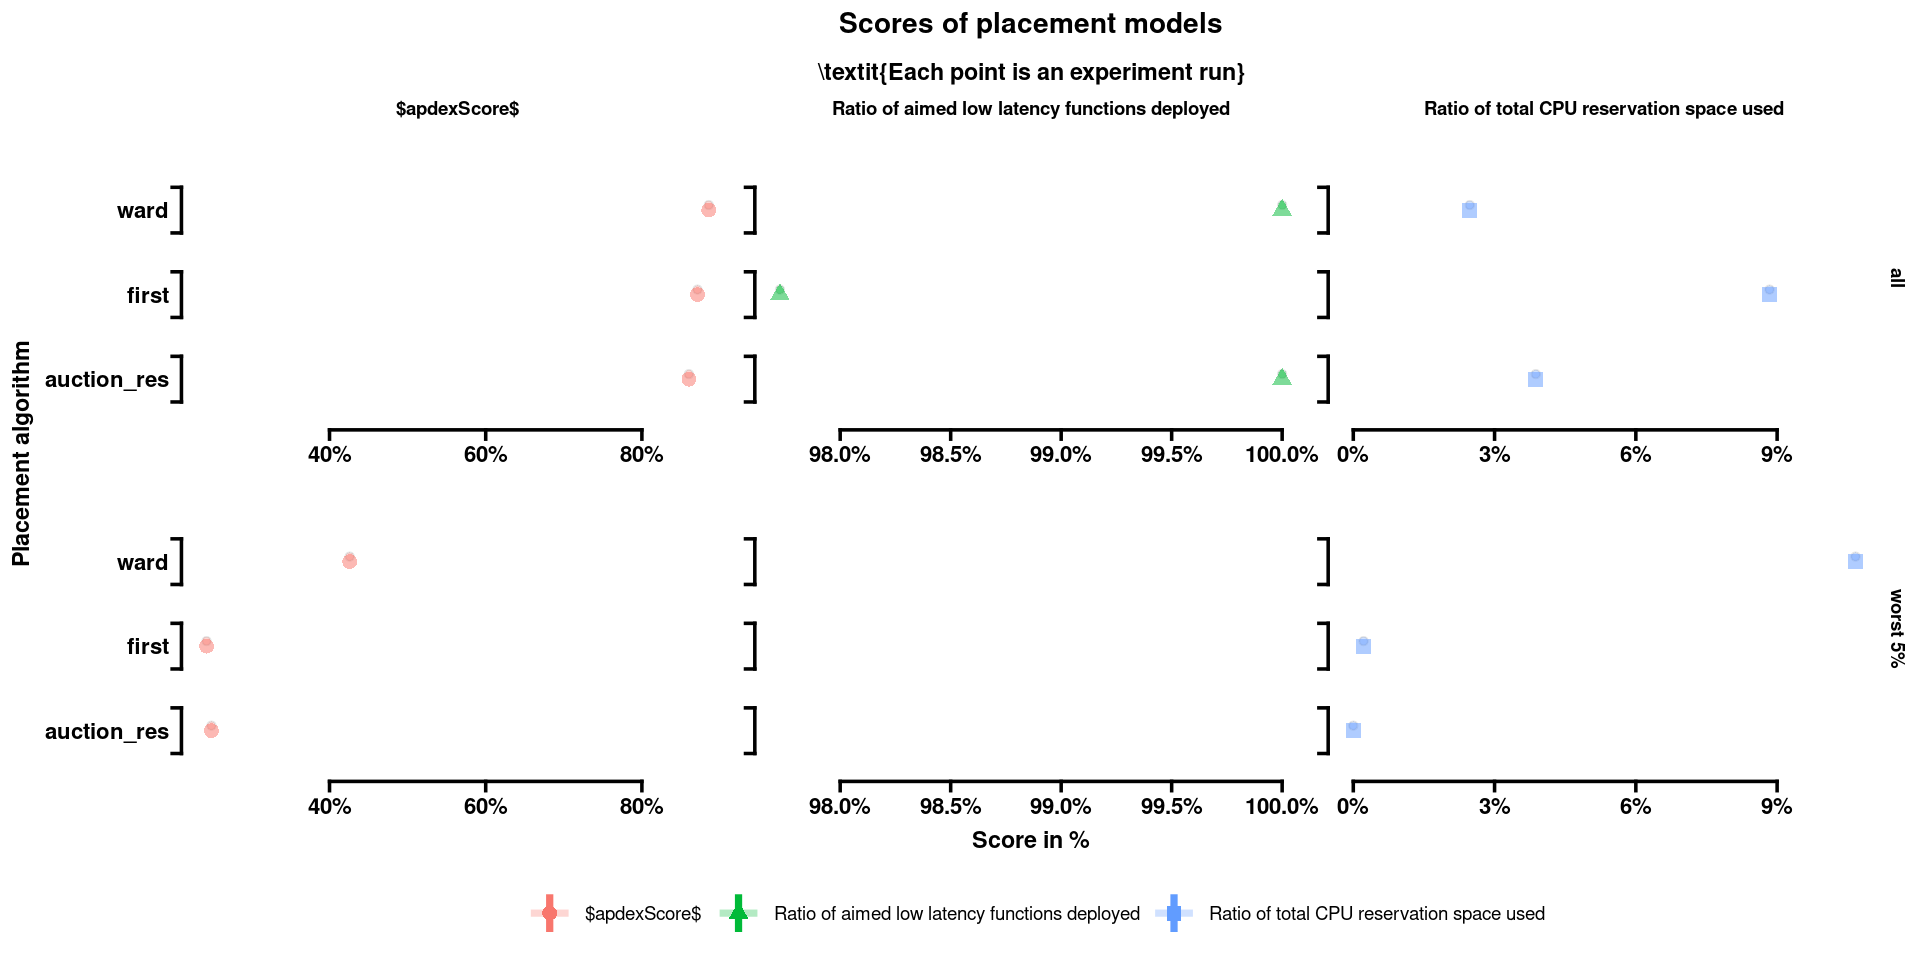

In [41]:
auc_usage_here <- auc_usage %>%
  group_by(metric_group, folder, metric_group_group) %>%
  summarise(usage = mean(usage_ratio))

apdex_plot <- apdex_data_line %>%
  inner_join(ratio_low_latency, by = c("metric_group", "metric_group_group", "folder")) %>%
  group_by(metric_group, folder, metric_group_group, ratio_low_latency, ratio_low_latency_functions) %>%
  summarise(apdex = mean(apdex)) %>%
  inner_join(auc_usage_here, by = c("metric_group", "metric_group_group", "folder")) %>%
  {
    .
  }

apdex_plot_1_percent <- apdex_data_line %>%
  inner_join(ratio_low_latency, by = c("metric_group", "metric_group_group", "folder")) %>%
  group_by(metric_group, folder, metric_group_group, ratio_low_latency, ratio_low_latency_functions) %>%
  arrange(apdex, .by_group = T) %>%
  mutate(rank = row_number()) %>%
  filter(rank <= ceiling(n() * 0.05)) %>%
  summarise(apdex = mean(apdex)) %>%
  inner_join(auc_usage %>%
    group_by(metric_group, folder, metric_group_group) %>%
    arrange(usage, .by_group = T) %>%
    mutate(rank = row_number()) %>%
    filter(rank <= ceiling(n() * 0.05)) %>%
    summarise(usage = mean(usage_ratio)), by = c("metric_group", "metric_group_group", "folder"))
finish_touch <- function(x) {
  return(x %>%
    mutate(diff = ratio_low_latency / ratio_low_latency_functions) %>%
    mutate(total_score = 1 / 3 * (diff + apdex + usage)) %>%
    group_by(metric_group, folder) %>%
    select(total_score, usage, diff, apdex, metric_group, folder) %>%
    gather(key = "score_type", value = "score", apdex, diff, usage) %>%
    mutate(score_type_rich = case_when(
      score_type == "apdex" ~ "$apdexScore$",
      score_type == "diff" ~ "Ratio of aimed low latency functions deployed",
      score_type == "usage" ~ "Ratio of total CPU reservation space used",
      score_type == "total_score" ~ "Average of all scores"
    )) %>%
    {
      .
    })
}

apdex_plot <- finish_touch(apdex_plot) %>%
  mutate(data_focus = "all") %>%
  full_join(finish_touch(apdex_plot_1_percent) %>% filter(score_type != "diff") %>% mutate(data_focus = "worst 5%"), by = c("folder", "metric_group", "data_focus", "score_type", "score", "score_type_rich"))

# apdex_plot
fig(16, 8)
apdex_plot <- apdex_plot %>%
  correct_names() %>%
  ggplot(
    aes(
      y = `Placement method`,
      x = score,
      color = score_type_rich,
      shape = score_type_rich,
      fill = score_type_rich,
    )
  ) +
  # stat_dotsinterval(dotsize = 0.6, position = "dodge") +
  # gghighlight(metric_group == "auction", unhighlighted_params = list(dotsize = 0.6, colour = NULL, fill = NULL, alpha = 0.3), label_params = list(linewidth = 10)) +
  # stat_dotsinterval(quantiles=100,position = "dodge", bindwidth = 1.6, dotsize = 1.6, scale = 0.9) +
  # gghighlight(metric_group == "auction", unhighlighted_params = list(point_alpha = 0.9, scale = 0.9, bindwidth = 1.6, dotsize = 1.6, colour = NULL, fill = NULL, alpha = 0.3), label_params = list(linewidth = 10), calculate_per_facet = TRUE) +
  stat_dotsinterval(slab_alpha = 0.6, position = "dodge", binwidth = unit(2, "mm"), scale = 0.95, size = 10, slab_linewidth = 0) +
  gghighlight(metric_group == "auction", unhighlighted_params = list(slab_alpha = 0.3, point_alpha = 0.3, colour = NULL, fill = NULL, alpha = 0.3), label_params = list(linewidth = 10), calculate_per_facet = TRUE) +
  facet_grid2(rows = vars(data_focus), cols = vars(score_type_rich), scales = "free_x", axes = "all", remove_labels = "y") +
  scale_x_continuous(label = scales::percent) +
  coord_cartesian(clip = "off") +
  labs(
    x = "Score in %",
    y = "Placement algorithm",
    title = "Scores of placement models",
    subtitle = "\\textit{Each point is an experiment run}",
    color = "Score type",
    fill = "Score type",
    shape = "Score type"
  ) +
  theme(
    legend.position = "bottom",
    # panel.border=element_blank(), axis.line=element_line()
    # legend.direction = "vertical",
  ) +
  coord_capped_cart(bottom = "both") +
  # capped_horizontal(capped = c("both", "left", "right", "none")) +
  # scale_x_continuous(guide = capped_horizontal(capped = c("both", "left", "right", "none"))) +
  scale_y_discrete(guide = guide_prism_bracket(width = 0.15))

apdex_plot


`summarise()` has grouped output by 'folder'. You can override using the `.groups` argument.


folder,period,failed
<chr>,<dbl>,<dbl>


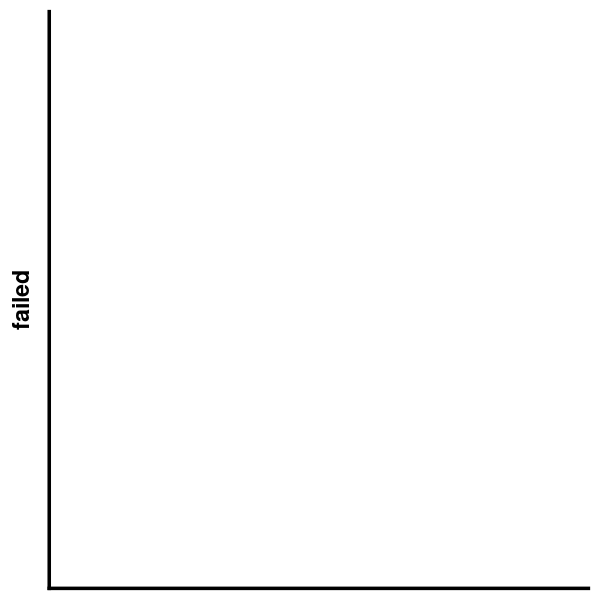

In [42]:
fails <- errors %>%
  group_by(folder, period) %>%
  summarise(failed = sum(value))

fails <- fails %>%
  # mutate(load = 1000 / period) %>%
  # inner_join(evol_sla_data, c("folder", "load")) %>%
  # mutate(dropped = failed / (above + respected + failed)) %>%
  {
    .
  }

fails

# fails <- evol_sla_data %>%
#     group_by(folder, target_offset) %>%
#     select(folder, target_offset) %>%
#     left_join(fails, by = c("folder")) %>%
#     {.}
# fails$dropped <- coalesce(fails$dropped, 0)


fails <- fails %>%
  ggplot(
    aes(
      x = folder,
      y = failed,
      # color = latency_type,
    )
  ) +
  # geom_line() +
  geom_point() +
  # geom_rug(sides="l") +
  # scale_y_reverse(label=scales::percent) +
  # scale_y_reverse()+
  # scale_x_discrete(position = "top") +
  # labs(
  #   x = "Load (req/s)",
  #   y = "Errors",
  #   # title = "Ratio of errors for send window vs load.",
  #   color = "Placment model"
  # ) +
  theme(
    axis.title.x = element_blank()
  ) +
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE)

fig(5, 5)
fails
# cowplot::plot_grid(evol_sla, fails, ncol = 1, rel_heights = c(1, 0.75))


In [43]:
deployment_times_raw <-
  load_csv("market_function_deployment_time.csv") %>%
  prepare() %>%
  extract_function_name_info()

# head(deployment_times_raw)


In [44]:
deployment_times <- deployment_times_raw %>%
  select(load_type, bid_id, latency_type, function_name, metric_group, value, metric_group_group) %>%
  distinct() %>%
  drop_na() %>%
  group_by(load_type, latency_type, bid_id, function_name, metric_group, metric_group_group) %>%
  summarize(min_time = min(value), avg_time = mean(value), max_time = max(value)) %>%
  {
    .
  }

# head(deployment_times)
fig(10, 10)
toto <- deployment_times %>%
  ggplot(
    aes(
      x = avg_time * 1000,
      # y = value,
      color = metric_group,
    )
  ) +
  stat_ecdf() +
  gghighlight(metric_group == "auction", unhighlighted_params = list(colour = NULL, alpha = 0.3), label_params = list(linewidth = 10)) +
  scale_x_continuous(trans = "log10") +
  # facet_grid(rows = varslatency_type) +
  # facet_grid(rows = vars(latency_type), cols = vars(load_type), scales = "free") +
  labs(
    x = "Deployment time (ms)",
    y = "Cumulation",
    title = "ECDF of time to deploy functions",
    color = "Placement model"
  )
# scale_color_viridis(discrete = TRUE, option = "D") +
# scale_fill_viridis(discrete = TRUE)


`summarise()` has grouped output by 'load_type', 'latency_type', 'bid_id', 'function_name', 'metric_group'. You can override using the `.groups` argument.
Warning message:
“Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation...”


`summarise()` has grouped output by 'folder', 'metric_group', 'metric_group_group'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'folder', 'metric_group', 'metric_group_group'. You can override using the `.groups` argument.
Warning message:
“Ignoring unknown parameters: slab_linewidth”
Warning message:
“Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation...”


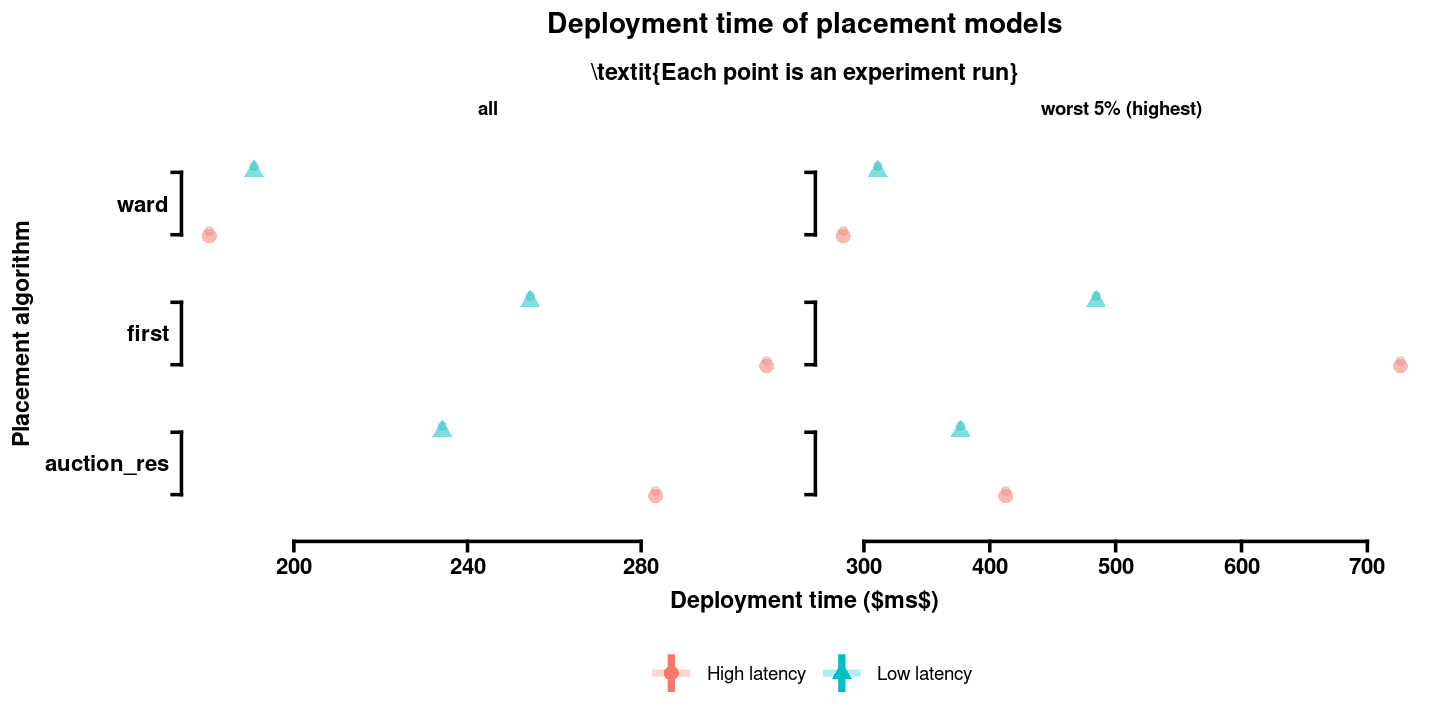

In [45]:
deployment_times <- deployment_times_raw %>%
  ungroup() %>%
  select(latency_type, sla_id, folder, metric_group, value, metric_group_group) %>%
  distinct() %>%
  drop_na()

top_1_percent <- deployment_times %>%
  group_by(folder, metric_group, metric_group_group, latency_type) %>%
  arrange(desc(value), .by_group = T) %>%
  mutate(rank = row_number()) %>%
  filter(rank <= ceiling(n() * 0.05)) %>%
  group_by(folder, metric_group, metric_group_group, latency_type) %>%
  summarize(avg_time_1_percent = mean(value))


deployment_times <- deployment_times %>%
  group_by(folder, metric_group, metric_group_group, latency_type) %>%
  summarize(avg_time = mean(value)) %>%
  inner_join(top_1_percent, by = c("folder", "metric_group", "metric_group_group", "latency_type")) %>%
  gather(key = "average_type", value = "average", avg_time, avg_time_1_percent) %>%
  mutate(average_type = case_when(
    average_type == "avg_time" ~ "all",
    average_type == "avg_time_1_percent" ~ "worst 5% (highest)",
  )) %>%
  {
    .
  }

deployment_times <- deployment_times %>%
  inner_join(total_low_latency, by = c("metric_group", "metric_group_group", "folder")) %>%
  mutate(ratio_low_latency_functions = paste0(round(ratio_low_latency_functions * 100, 0), "%"))


fig(12, 7)
deployment_times_all <- deployment_times %>%
  # filter(average_type == "all") %>%
  correct_names() %>%
  ggplot(
    aes(
      y = `Placement method`,
      x = average * 1000,
      color = latency_type,
      shape = latency_type,
      fill = latency_type,
      # group = `Placement method`
      # dotsize = 0.6,
      # bindwidth=0.5,
      # # group = average_type,
      # linewidth=0,
    )
  ) +
  stat_dotsinterval(slab_alpha = 0.6, position = "dodge", binwidth = unit(2, "mm"), scale = 0.95, size = 10, slab_linewidth = 0) +
  gghighlight(metric_group == "auction", unhighlighted_params = list(slab_alpha = 0.3, point_alpha = 0.3, colour = NULL, fill = NULL, alpha = 0.3), label_params = list(linewidth = 10), calculate_per_facet = TRUE) +
  facet_grid2(cols = vars(average_type), scales = "free", axes = "all", remove_labels = "y") +
  labs(
    x = "Deployment time ($ms$)",
    y = "Placement algorithm",
    title = "Deployment time of placement models",
    subtitle = "\\textit{Each point is an experiment run}",
    color = "Function type",
    shape = "Function type",
    fill = "Function type",
  ) +
  theme(
    legend.position = "bottom",
    # legend.direction = "vertical",
  ) +
  coord_capped_cart(bottom = "both") +
  scale_y_discrete(guide = guide_prism_bracket(width = 0.15))
fig(12, 6)
deployment_times_all


In [46]:
# nb_experiences_per_categories <- total_low_latency %>%
#     ungroup()  %>%
#     select(folder, metric_group, ratio_low_latency_functions) %>%
#     group_by(metric_group, ratio_low_latency_functions) %>%
#     distinct() %>%
#     count() %>%
#     mutate(ratio_low_latency_functions = paste0(round(ratio_low_latency_functions * 100, 0), "%")) %>%
#     pivot_wider(names_from = ratio_low_latency_functions, values_from = n) %>%
#     rowwise() %>%
#     mutate(total = sum(c_across(c(`25%`, `50%`, `75%`)))) %>%
#     ungroup() %>%
#     correct_names() %>%
#     select(-metric_group) %>%
#     select(`Placement method`, "25%", "50%", "75%", "total")

# nb_experiences_per_categories


In [47]:
escape_latex_special_chars <- function(text) {
  # Define special characters to escape
  special_chars <- c("%", "&", "#", "_", "\\$", "\\{", "\\}", "\\^", "\\~")

  # Escape each special character with a backslash
  for (char in special_chars) {
    text <- gsub(char, paste0("\\", substring(char, nchar(char), nchar(char))), text, fixed = TRUE)
  }

  return(text)
}


tibble_to_latex_tabular <- function(data, file) {
  cat("\\begin{tabular}{", paste0(rep("c", ncol(data)), collapse = " "), "}\n", file = file)
  cat("\\hline\n", file = file, append = TRUE)

  # Print column names with escaped special characters
  cat(paste0(escape_latex_special_chars(colnames(data)), collapse = " & "), " \\\\\n", file = file, append = TRUE)
  cat("\\hline\n", file = file, append = TRUE)

  # Print rows with escaped special characters
  for (i in 1:nrow(data)) {
    cat(paste0(escape_latex_special_chars(as.character(data[i, ])), collapse = " & "), " \\\\\n", file = file, append = TRUE)
  }

  cat("\\hline\n", file = file, append = TRUE)
  cat("\\end{tabular}", file = file, append = TRUE)
}


In [48]:
if (length(find.package("tikzDevice", quiet = TRUE))) {
    library(tikzDevice)
    options(tikzDefaultEngine = "xetex")
    options(
        tikzSanitizeCharacters = c("%"),
        tikzReplacementCharacters = c("\\%")
    )

    tikzDevice::tikz("./nodes.tex", width = 15, height = 5, standAlone = FALSE, sanitize = TRUE) # , standAlone = TRUE)
    plot(net_connected, layout = coords, asp = 0.22, margin = -0, edge.label = E(net_connected)$weight, edge.width = 1, vertex.size = 5, vertex.label.cex = 1, vertex.dist = 20, edge.arrow.size = 0.5, edge.label.cex = 0.8, edge.label.dist = 1.5)
    dev.off()

    tikzDevice::tikz("./deploymenttimes.tex", width = 12, height = 6, standAlone = FALSE, sanitize = TRUE) # , standAlone = TRUE)
    print(deployment_times_all)
    dev.off()

    tikzDevice::tikz("./apdex.tex", width = 12, height = 6, standAlone = FALSE, sanitize = TRUE) # , standAlone = TRUE)
    print(apdex_plot)
    dev.off()

    tikzDevice::tikz("./nb_bids.tex", width = 12, height = 6, standAlone = FALSE, sanitize = TRUE) # , standAlone = TRUE)
    print(bids_function_plot)
    dev.off()

    tikzDevice::tikz("./earnings.tex", width = 12, height = 4, standAlone = FALSE, sanitize = TRUE) # , standAlone = TRUE)
    print(transform_ratio_graph_plot_earnings)
    dev.off()

    tikzDevice::tikz("./jain.tex", width = 9, height = 4, standAlone = FALSE, sanitize = TRUE) # , standAlone = TRUE)
    print(transform_ratio_graph_plot_jain)
    dev.off()

    tikzDevice::tikz("./sum_earnings.tex", width = 9, height = 4, standAlone = FALSE, sanitize = TRUE) # , standAlone = TRUE)
    print(transform_ratio_graph_plot_sum_earnings)
    dev.off()

    output_file <- "nb_experiences_per_categories.tex"
    tibble_to_latex_tabular(nb_experiences_per_categories, output_file)
}
